In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,month_plot
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import itertools
from IPython.display import display
import warnings 
warnings.filterwarnings("ignore")

# Problem 1 - Rose Wine Data Analysis

In [2]:
ds=pd.read_csv('C:/Users/dheepig/Desktop/Dheepika/Great Lakes/Session 7- Time Series Forecasting/Project/Datasets/Rose.csv')
ds.head()

YearMonth   Rose
0   1980-01  112.0
1   1980-02  118.0
2   1980-03  129.0
3   1980-04   99.0
4   1980-05  116.0

# Question 1. Read the data as an appropriate Time Series data and plot the data.

In [3]:
dup=ds.duplicated().sum()
print("There are total of {}".format(dup), "duplicate records in the dataset")

There are total of 0 duplicate records in the dataset


In [4]:
dups=ds.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [5]:
ds.drop_duplicates(subset=None,keep='first',inplace=True)

In [6]:
ds.dtypes

YearMonth     object
Rose         float64
dtype: object

In [7]:
ds.skew(axis=0,skipna=True)

Rose    1.266468
dtype: float64

In [8]:
ds.kurtosis(axis=0,skipna=True)

Rose    2.832293
dtype: float64

In [9]:
for column in ds.columns:
    if ds[column].dtype !='object':
        median=ds[column].median()
        ds[column]=ds[column].fillna(median)
ds.isnull().sum()  

YearMonth    0
Rose         0
dtype: int64

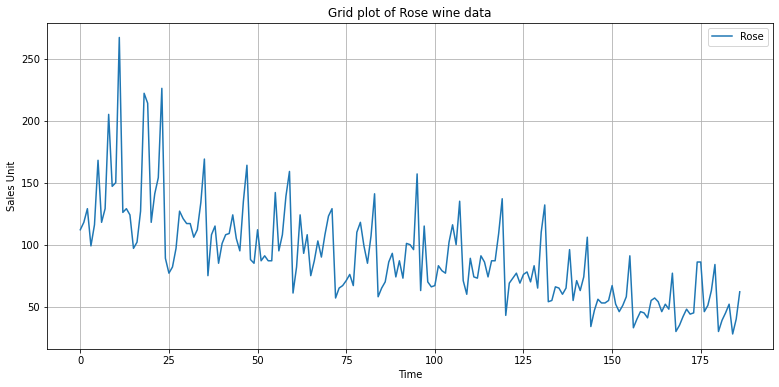

In [10]:
ds.plot();
plt.title("Grid plot of Rose wine data")
plt.xlabel("Time")
plt.ylabel("Sales Unit")
plt.grid()

In [11]:
date = pd.date_range(start='01/01/1980', end='08/01/1995', freq='M')
date

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '1994-10-31', '1994-11-30', '1994-12-31', '1995-01-31',
               '1995-02-28', '1995-03-31', '1995-04-30', '1995-05-31',
               '1995-06-30', '1995-07-31'],
              dtype='datetime64[ns]', length=187, freq='M')

In [12]:
ds['Time_Stamp'] = pd.DataFrame(date,columns=['Month'])

In [13]:
ds.head()

YearMonth   Rose Time_Stamp
0   1980-01  112.0 1980-01-31
1   1980-02  118.0 1980-02-29
2   1980-03  129.0 1980-03-31
3   1980-04   99.0 1980-04-30
4   1980-05  116.0 1980-05-31

In [14]:
ds['Time_Stamp']=pd.to_datetime(ds['Time_Stamp'])
ds= ds.set_index('Time_Stamp')
ds.drop(['YearMonth'],axis=1, inplace = True)
ds.head()

Rose
Time_Stamp       
1980-01-31  112.0
1980-02-29  118.0
1980-03-31  129.0
1980-04-30   99.0
1980-05-31  116.0

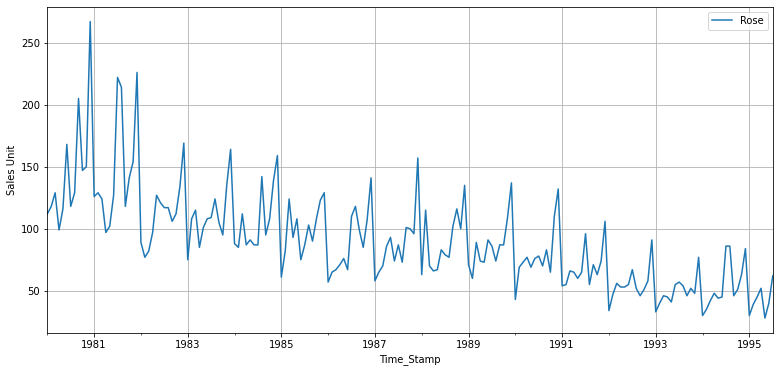

In [15]:
ds.plot();
plt.ylabel("Sales Unit")
plt.grid()

# 2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

In [16]:
ds.describe()

Rose
count  187.000000
mean    90.347594
std     38.966791
min     28.000000
25%     63.000000
50%     86.000000
75%    111.000000
max    267.000000

In [17]:
ds.describe(include='all')

Rose
count  187.000000
mean    90.347594
std     38.966791
min     28.000000
25%     63.000000
50%     86.000000
75%    111.000000
max    267.000000

In [18]:
row, col = ds.shape
print("There are total {}".format(row), "rows and {}".format(col), "columns in the dataset")

There are total 187 rows and 1 columns in the dataset


In [19]:
ds.isnull().any()

Rose    False
dtype: bool

In [20]:
ds.isnull().sum()

Rose    0
dtype: int64

In [21]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-31 to 1995-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    187 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


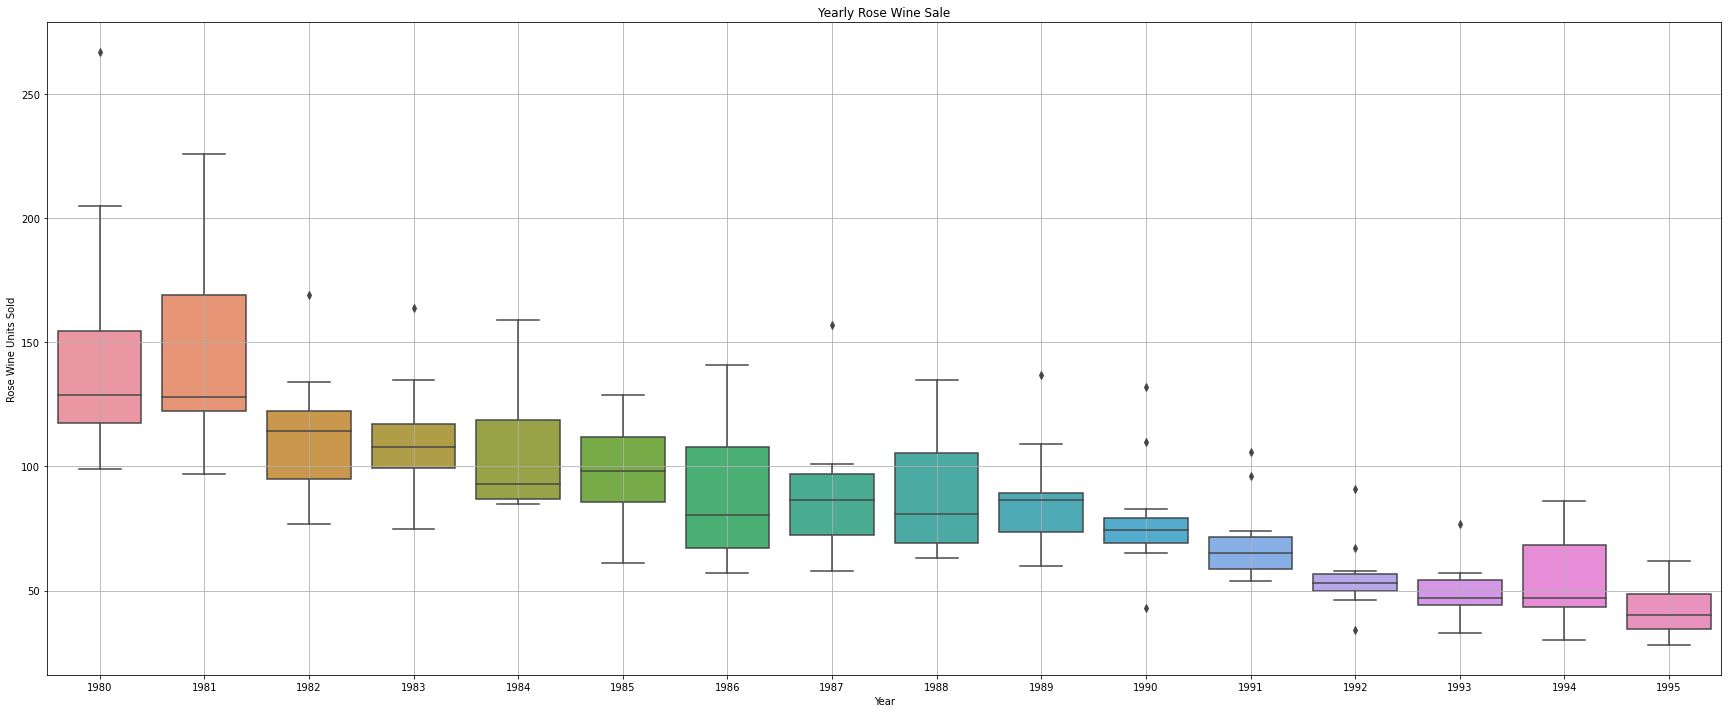

In [22]:
_, ax = plt.subplots(figsize=(30,12)) #yearly plot
sns.boxplot(x = ds.index.year,y = ds.values[:,0],ax=ax)
plt.title('Yearly Rose Wine Sale');
plt.xlabel('Year');
plt.ylabel('Rose Wine Units Sold');
plt.grid();

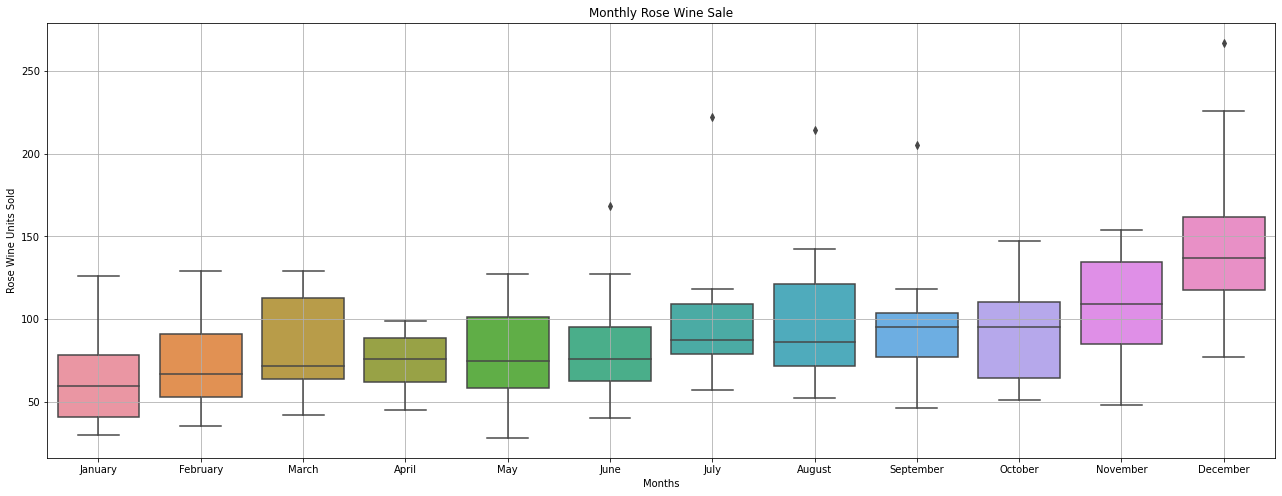

In [23]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = ds.index.month_name(),y = ds.values[:,0],ax=ax)
plt.title('Monthly Rose Wine Sale');
plt.xlabel('Months')
plt.ylabel('Rose Wine Units Sold');
plt.grid();

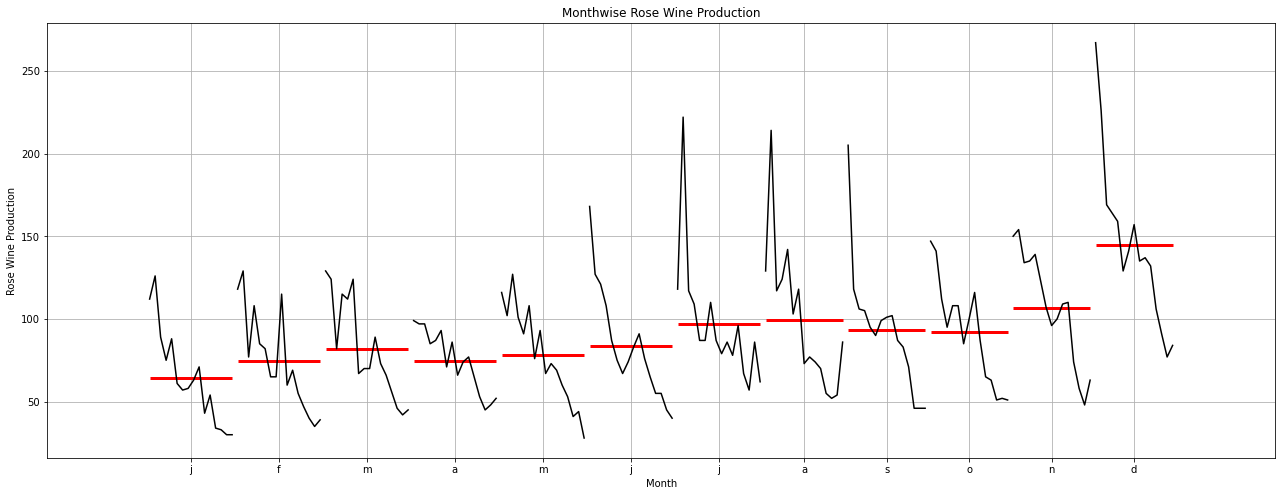

In [24]:
fig, ax = plt.subplots(figsize=(22,8))
plt.title('Monthwise Rose Wine Production')
plt.xlabel('Month')
month_plot(ds,ylabel='Rose Wine Production',ax=ax)
plt.grid();

In [25]:
monthly_sales_across_years = pd.pivot_table(ds, values = 'Rose', columns = ds.index.month_name(), index = ds.index.year)
monthly_sales_across_years

Time_Stamp  April  August  December  February  January   July   June  March  \
Time_Stamp                                                                    
1980         99.0   129.0     267.0     118.0    112.0  118.0  168.0  129.0   
1981         97.0   214.0     226.0     129.0    126.0  222.0  127.0  124.0   
1982         97.0   117.0     169.0      77.0     89.0  117.0  121.0   82.0   
1983         85.0   124.0     164.0     108.0     75.0  109.0  108.0  115.0   
1984         87.0   142.0     159.0      85.0     88.0   87.0   87.0  112.0   
1985         93.0   103.0     129.0      82.0     61.0   87.0   75.0  124.0   
1986         71.0   118.0     141.0      65.0     57.0  110.0   67.0   67.0   
1987         86.0    73.0     157.0      65.0     58.0   87.0   74.0   70.0   
1988         66.0    77.0     135.0     115.0     63.0   79.0   83.0   70.0   
1989         74.0    74.0     137.0      60.0     71.0   86.0   91.0   89.0   
1990         77.0    70.0     132.0      69.0     43.0   78.0   76.0   73.0   
1991         65.0    55.0     106.0      55.0     54.0   96.0   65.0   66.0   
1992         53.0    52.0      91.0      47.0     34.0   67.0   55.0   56.0   
1993         45.0    54.0      77.0      40.0     33.0   57.0   55.0   46.0   
1994         48.0    86.0      84.0      35.0     30.0   86.0   45.0   42.0   
1995         52.0     NaN       NaN      39.0     30.0   62.0   40.0   45.0   

Time_Stamp    May  November  October  September  
Time_Stamp                                       
1980        116.0     150.0    147.0      205.0  
1981        102.0     154.0    141.0      118.0  
1982        127.0     134.0    112.0      106.0  
1983        101.0     135.0     95.0      105.0  
1984         91.0     139.0    108.0       95.0  
1985        108.0     123.0    108.0       90.0  
1986         76.0     107.0     85.0       99.0  
1987         93.0      96.0    100.0      101.0  
1988         67.0     100.0    116.0      102.0  
1989         73.0     109.0     87.0       87.0  
1990         69.0     110.0     65.0       83.0  
1991         60.0      74.0     63.0       71.0  
1992         53.0      58.0     51.0       46.0  
1993         41.0      48.0     52.0       46.0  
1994         44.0      63.0     51.0       46.0  
1995         28.0       NaN      NaN        NaN

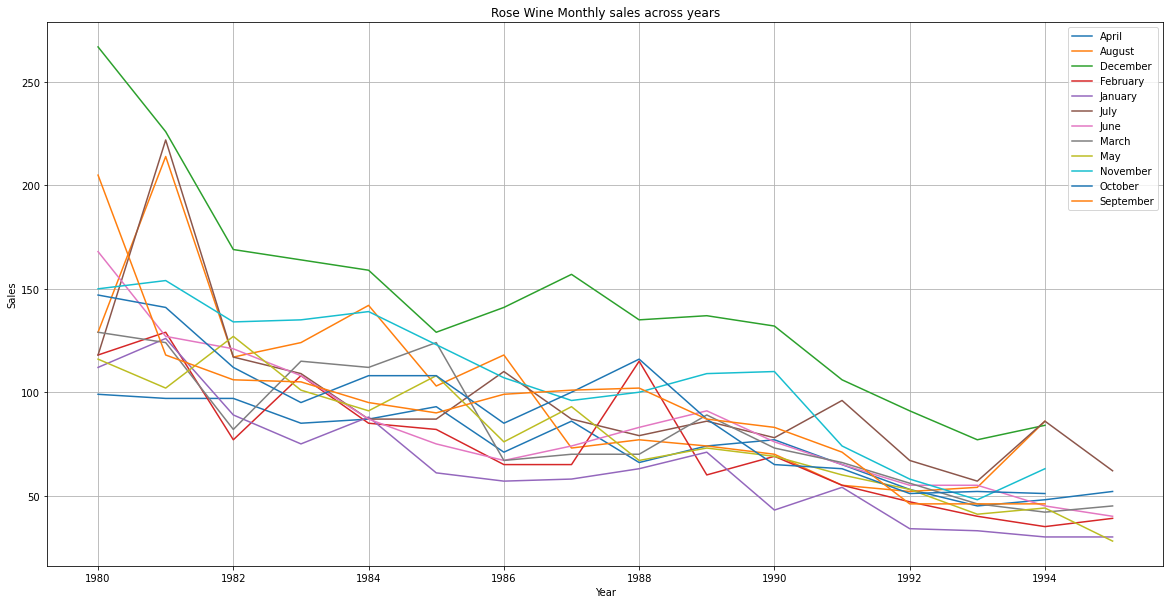

In [26]:
monthly_sales_across_years.plot(figsize=(20,10))
plt.grid()
plt.title('Rose Wine Monthly sales across years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(loc='best');

def detect_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range=Q1-(1.5 * IQR)
    upper_range=Q3+(1.5 * IQR)
    return lower_range,upper_range

In [27]:
ds_yearly_sum = ds.resample('A').sum()
ds_yearly_sum.head()

Rose
Time_Stamp        
1980-12-31  1758.0
1981-12-31  1780.0
1982-12-31  1348.0
1983-12-31  1324.0
1984-12-31  1280.0

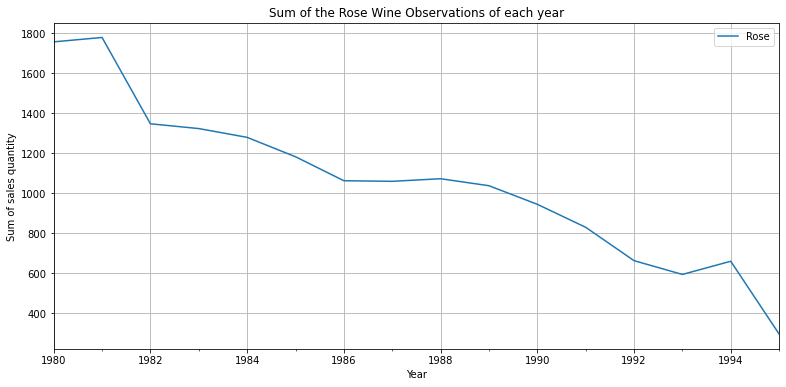

In [28]:
ds_yearly_sum.plot();
plt.grid()
plt.title('Sum of the Rose Wine Observations of each year')
plt.ylabel('Sum of sales quantity')
plt.xlabel('Year');

In [29]:
ds_yearly_mean = ds.resample('Y').mean()
ds_yearly_mean.head()

Rose
Time_Stamp            
1980-12-31  146.500000
1981-12-31  148.333333
1982-12-31  112.333333
1983-12-31  110.333333
1984-12-31  106.666667

Text(0, 0.5, 'Mean of Sales')

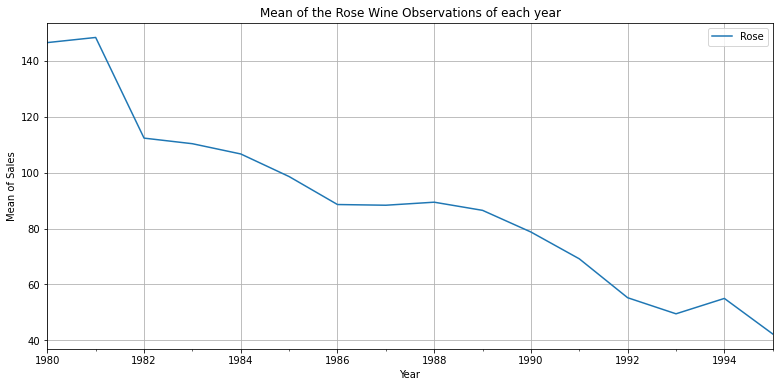

In [30]:
ds_yearly_mean.plot();
plt.grid()
plt.title('Mean of the Rose Wine Observations of each year');
plt.xlabel('Year')
plt.ylabel('Mean of Sales')

In [31]:
ds_quarterly_sum = ds.resample('Q').sum()
ds_quarterly_sum.head()

Rose
Time_Stamp       
1980-03-31  359.0
1980-06-30  383.0
1980-09-30  452.0
1980-12-31  564.0
1981-03-31  379.0

Text(0, 0.5, 'Sum of Sales Quantity')

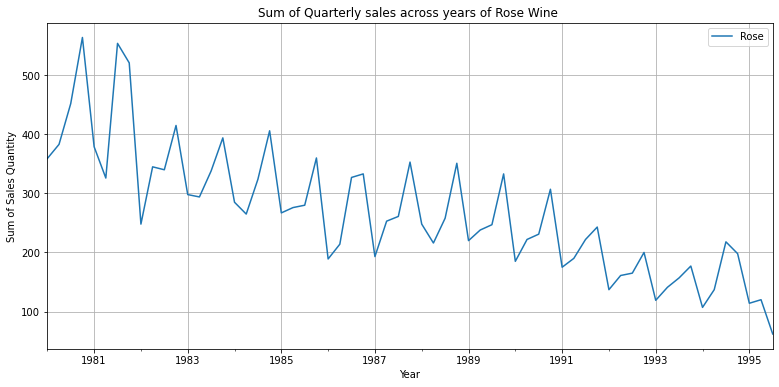

In [32]:
ds_quarterly_sum.plot();
plt.grid()
plt.title('Sum of Quarterly sales across years of Rose Wine ');
plt.xlabel('Year')
plt.ylabel('Sum of Sales Quantity')

In [33]:
ds_quarterly_mean = ds.resample('Q').mean()
ds_quarterly_mean.head()

Rose
Time_Stamp            
1980-03-31  119.666667
1980-06-30  127.666667
1980-09-30  150.666667
1980-12-31  188.000000
1981-03-31  126.333333

Text(0, 0.5, 'Mean of Sales Quantity')

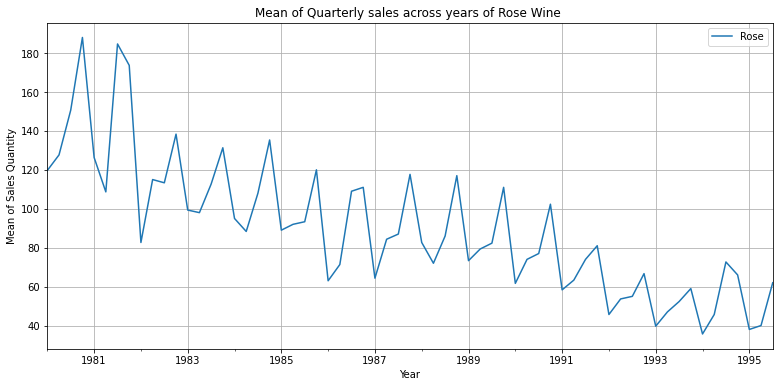

In [34]:
ds_quarterly_mean.plot();
plt.grid()
plt.title('Mean of Quarterly sales across years of Rose Wine ');
plt.xlabel('Year')
plt.ylabel('Mean of Sales Quantity')

In [35]:
ds_daily_sum = ds.resample('D').sum()
ds_daily_sum

Rose
Time_Stamp       
1980-01-31  112.0
1980-02-01    0.0
1980-02-02    0.0
1980-02-03    0.0
1980-02-04    0.0
...           ...
1995-07-27    0.0
1995-07-28    0.0
1995-07-29    0.0
1995-07-30    0.0
1995-07-31   62.0

[5661 rows x 1 columns]

Text(0, 0.5, 'Sum of Sales Quantity')

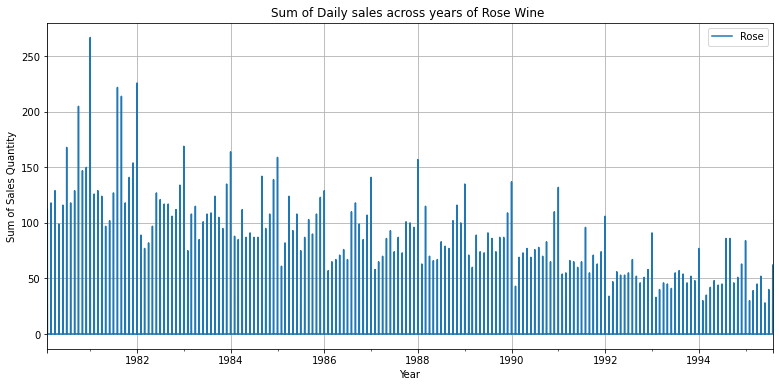

In [36]:
ds_daily_sum.plot()
plt.grid()
plt.title('Sum of Daily sales across years of Rose Wine ');
plt.xlabel('Year')
plt.ylabel('Sum of Sales Quantity')

In [37]:
ds_decade_sum = ds.resample('10Y').sum()
ds_decade_sum

Rose
Time_Stamp         
1980-12-31   1758.0
1990-12-31  12094.0
2000-12-31   3043.0

Text(0, 0.5, 'Sum of Decade Quantity')

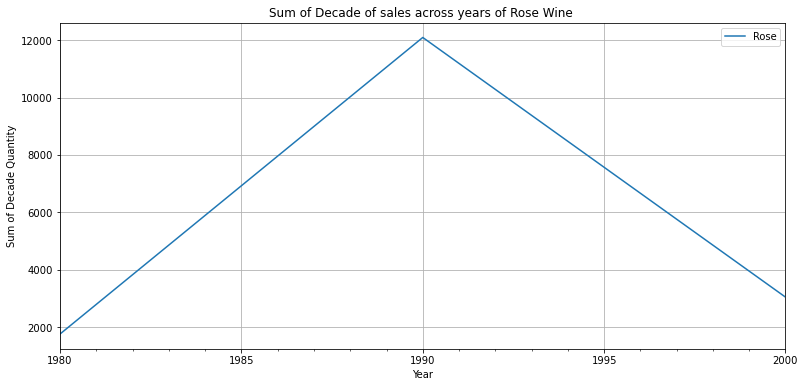

In [38]:
ds_decade_sum.plot();
plt.grid()
plt.title('Sum of Decade of sales across years of Rose Wine ');
plt.xlabel('Year')
plt.ylabel('Sum of Decade Quantity')

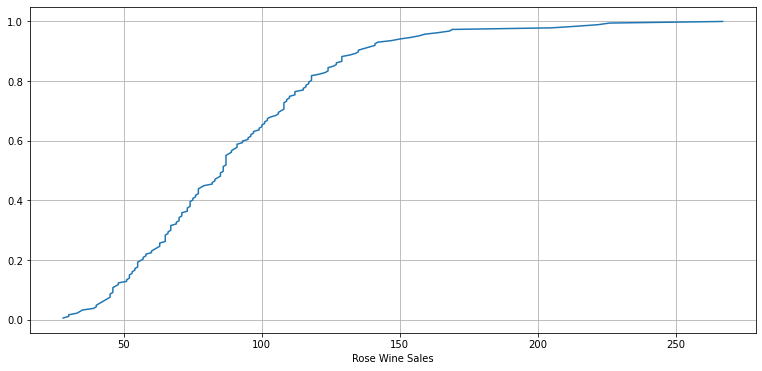

In [39]:
cds = ECDF(ds['Rose'])
plt.plot(cds.x, cds.y, label = "statmodels");
plt.grid()
plt.xlabel('Rose Wine Sales');

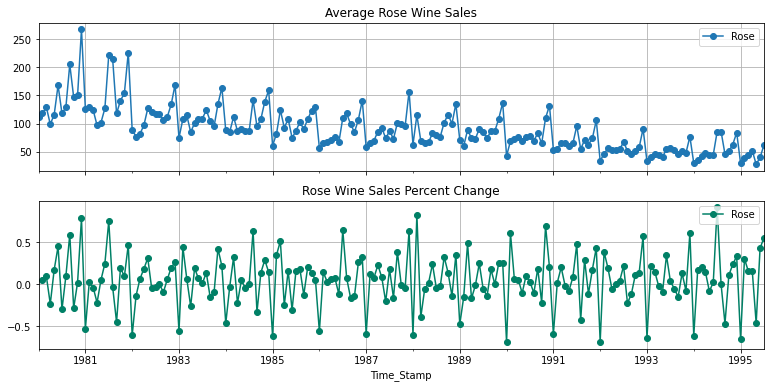

In [40]:
average = ds.groupby(ds.index)["Rose"].mean()
pct_change = ds.groupby(ds.index)["Rose"].sum().pct_change()
fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(13,6))
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Rose Wine Sales",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="Rose Wine Sales Percent Change",grid=True)

In [41]:
ds['1994']

Rose
Time_Stamp      
1994-01-31  30.0
1994-02-28  35.0
1994-03-31  42.0
1994-04-30  48.0
1994-05-31  44.0
1994-06-30  45.0
1994-07-31  86.0
1994-08-31  86.0
1994-09-30  46.0
1994-10-31  51.0
1994-11-30  63.0
1994-12-31  84.0

In [42]:
ds.interpolate(methods='spline',order=3,inplace=True)

In [43]:
ds['1994']

Rose
Time_Stamp      
1994-01-31  30.0
1994-02-28  35.0
1994-03-31  42.0
1994-04-30  48.0
1994-05-31  44.0
1994-06-30  45.0
1994-07-31  86.0
1994-08-31  86.0
1994-09-30  46.0
1994-10-31  51.0
1994-11-30  63.0
1994-12-31  84.0

In [44]:
ds.isna().sum()

Rose    0
dtype: int64

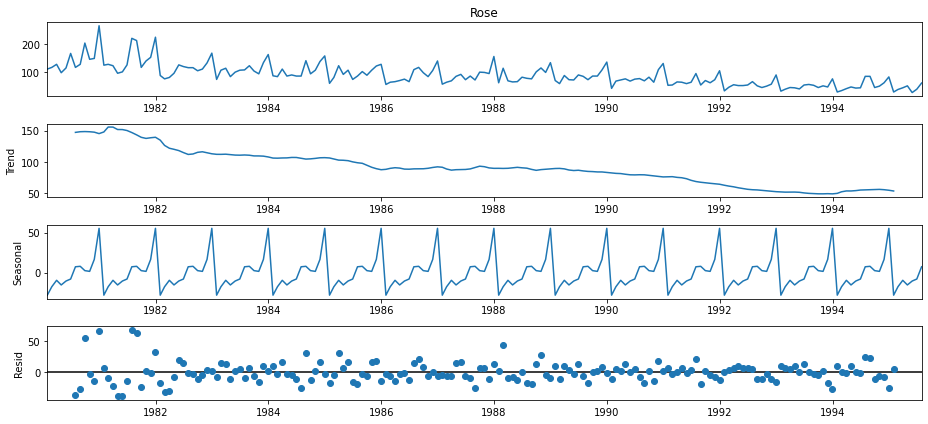

In [45]:
decomposition = seasonal_decompose(ds['Rose'],model='additive')
decomposition.plot();

In [46]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid
print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31    147.083333
1980-08-31    148.125000
1980-09-30    148.375000
1980-10-31    148.083333
1980-11-30    147.416667
1980-12-31    145.125000
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-31   -28.355258
1980-02-29   -17.794345
1980-03-31    -9.764583
1980-04-30   -15.577083
1980-05-31   -10.675298
1980-06-30    -8.157440
1980-07-31     7.161409
1980-08-31     7.741964
1980-09-30     2.328075
1980-10-31     1.425298
1980-11-30    16.400298
1980-12-31    55.266964
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-31          NaN
1980-02-29          NaN
1980-03-31          NaN
1980-04-30          NaN
1980-05-31          NaN
1980-06-30          NaN
1980-07-31   -36.244742
1980-08-31   -26.866964
1980-09-30    54.296925
1980-10-31    -2.508631
1980-11-30   -13.816964
1980-12-31    66.60

In [47]:
deaseasonalized_ts = trend + residual
deaseasonalized_ts.head(12)

Time_Stamp
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31    110.838591
1980-08-31    121.258036
1980-09-30    202.671925
1980-10-31    145.574702
1980-11-30    133.599702
1980-12-31    211.733036
dtype: float64

Text(0, 0.5, 'Sales')

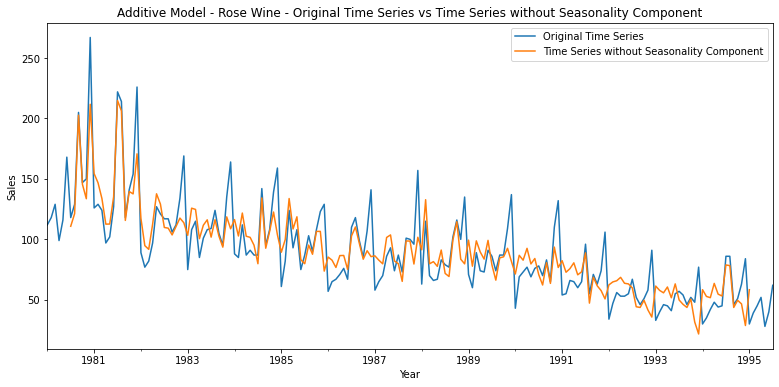

In [48]:
ds.plot()
deaseasonalized_ts.plot()
plt.legend(["Original Time Series", "Time Series without Seasonality Component"]);
plt.title('Additive Model - Rose Wine - Original Time Series vs Time Series without Seasonality Component')
plt.xlabel('Year')
plt.ylabel('Sales')

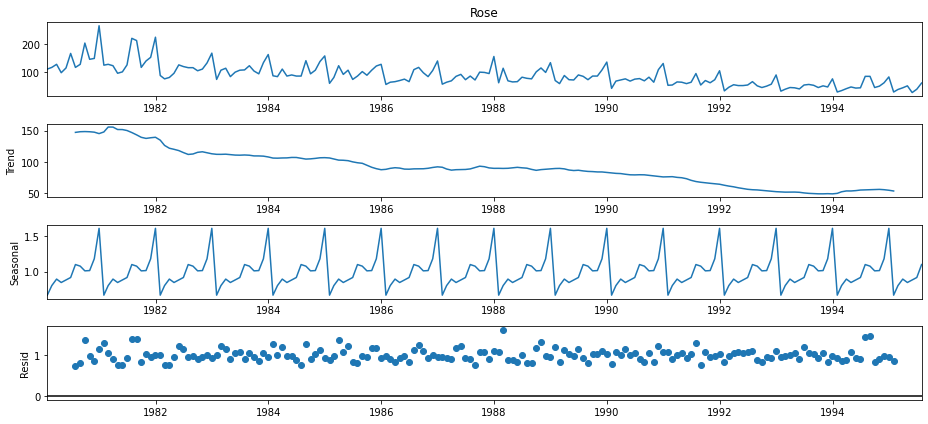

In [49]:
decomposition = seasonal_decompose(ds['Rose'],model='multiplicative')
decomposition.plot();

In [50]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid
print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31    147.083333
1980-08-31    148.125000
1980-09-30    148.375000
1980-10-31    148.083333
1980-11-30    147.416667
1980-12-31    145.125000
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-31    0.664904
1980-02-29    0.801176
1980-03-31    0.893234
1980-04-30    0.844896
1980-05-31    0.881276
1980-06-30    0.915970
1980-07-31    1.099977
1980-08-31    1.077255
1980-09-30    1.010266
1980-10-31    1.014454
1980-11-30    1.182097
1980-12-31    1.614497
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-31         NaN
1980-02-29         NaN
1980-03-31         NaN
1980-04-30         NaN
1980-05-31         NaN
1980-06-30         NaN
1980-07-31    0.729348
1980-08-31    0.808431
1980-09-30    1.367594
1980-10-31    0.978541
1980-11-30    0.860779
1980-12-31    1.139546
Name: resid, dtype:

In [51]:
deaseasonalized_ts = trend + residual
deaseasonalized_ts.head(12)

Time_Stamp
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31    147.812682
1980-08-31    148.933431
1980-09-30    149.742594
1980-10-31    149.061874
1980-11-30    148.277446
1980-12-31    146.264546
dtype: float64

Text(0, 0.5, 'Sales')

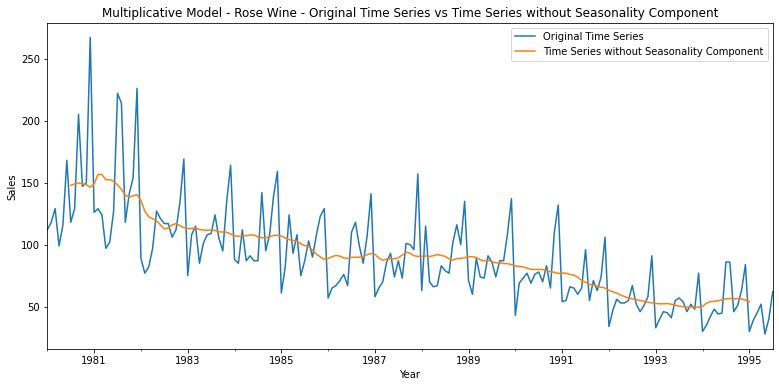

In [52]:
ds.plot()
deaseasonalized_ts.plot()
plt.legend(["Original Time Series", "Time Series without Seasonality Component"]);
plt.title('Multiplicative Model - Rose Wine - Original Time Series vs Time Series without Seasonality Component')
plt.xlabel('Year')
plt.ylabel('Sales')

# 3. Split the data into training and test. The test data should start in 1991.

### Splitting data into training and test set

In [53]:
train=ds[ds.index.year< 1991]
test=ds[ds.index.year>=1991]

In [54]:
print('Shape of Training Data is',train.shape)

Shape of Training Data is (132, 1)


In [55]:
print('Shape of Testing Data is',test.shape)

Shape of Testing Data is (55, 1)


In [56]:
print('First few rows of Training Data','\n',train.head(),'\n')
print('Last few rows of Training Data','\n',train.tail(),'\n')
print('First few rows of Test Data','\n',test.head(),'\n')
print('Last few rows of Test Data','\n',test.tail(),'\n')

First few rows of Training Data 
              Rose
Time_Stamp       
1980-01-31  112.0
1980-02-29  118.0
1980-03-31  129.0
1980-04-30   99.0
1980-05-31  116.0 

Last few rows of Training Data 
              Rose
Time_Stamp       
1990-08-31   70.0
1990-09-30   83.0
1990-10-31   65.0
1990-11-30  110.0
1990-12-31  132.0 

First few rows of Test Data 
             Rose
Time_Stamp      
1991-01-31  54.0
1991-02-28  55.0
1991-03-31  66.0
1991-04-30  65.0
1991-05-31  60.0 

Last few rows of Test Data 
             Rose
Time_Stamp      
1995-03-31  45.0
1995-04-30  52.0
1995-05-31  28.0
1995-06-30  40.0
1995-07-31  62.0 



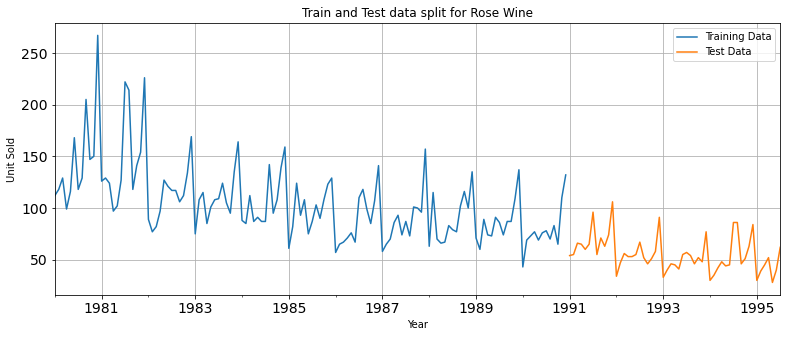

In [57]:
train['Rose'].plot(figsize=(13,5), fontsize=14)
test['Rose'].plot(figsize=(13,5), fontsize=14)
plt.title('Train and Test data split for Rose Wine')
plt.xlabel('Year')
plt.ylabel('Unit Sold')
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

# 4. Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models such as regression,naïve forecast models and simple average models. should also be built on the training data and check the performance on the test data using RMSE.

In [58]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+43 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]


### Model 1 : Linear Regression

In [59]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [60]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time
print('First few rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First few rows of Training Data 
              Rose  time
Time_Stamp             
1980-01-31  112.0     1
1980-02-29  118.0     2
1980-03-31  129.0     3
1980-04-30   99.0     4
1980-05-31  116.0     5 

Last few rows of Training Data 
              Rose  time
Time_Stamp             
1990-08-31   70.0   128
1990-09-30   83.0   129
1990-10-31   65.0   130
1990-11-30  110.0   131
1990-12-31  132.0   132 

First few rows of Test Data 
             Rose  time
Time_Stamp            
1991-01-31  54.0    43
1991-02-28  55.0    44
1991-03-31  66.0    45
1991-04-30  65.0    46
1991-05-31  60.0    47 

Last few rows of Test Data 
             Rose  time
Time_Stamp            
1995-03-31  45.0    93
1995-04-30  52.0    94
1995-05-31  28.0    95
1995-06-30  40.0    96
1995-07-31  62.0    97 



In [61]:
lr = LinearRegression()

In [62]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Rose'].values)

LinearRegression()

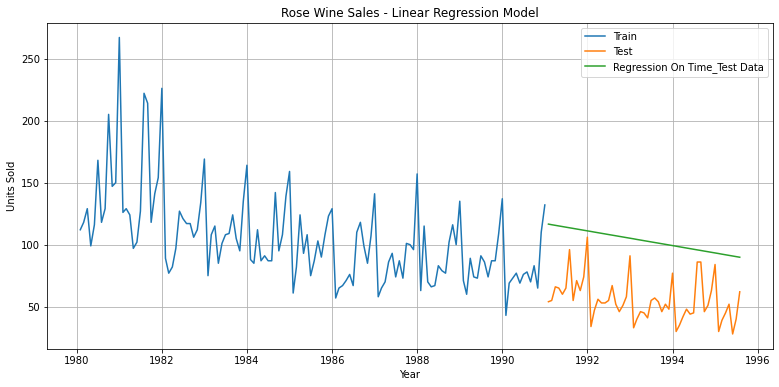

In [63]:
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1
plt.figure(figsize=(13,6))    
plt.title('Rose Wine Sales - Linear Regression Model')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

### Test Data - RMSE

In [64]:
rmse_model1_test = metrics.mean_squared_error(test['Rose'],test_predictions_model1,squared=False)
print("For RegressionOnTime forecast on the Test Data, RMSE is %3.3f"%(rmse_model1_test))

For RegressionOnTime forecast on the Test Data, RMSE is 50.573


In [65]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['RegressionOnTime'])
round(resultsDf,2)

Test RMSE
RegressionOnTime      50.57

### Model 2 : Naïve Approach

In [66]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [67]:
NaiveModel_test['naive'] = np.asarray(train['Rose'])[len(np.asarray(train['Rose']))-1]
NaiveModel_test['naive'].head()

Time_Stamp
1991-01-31    132.0
1991-02-28    132.0
1991-03-31    132.0
1991-04-30    132.0
1991-05-31    132.0
Name: naive, dtype: float64

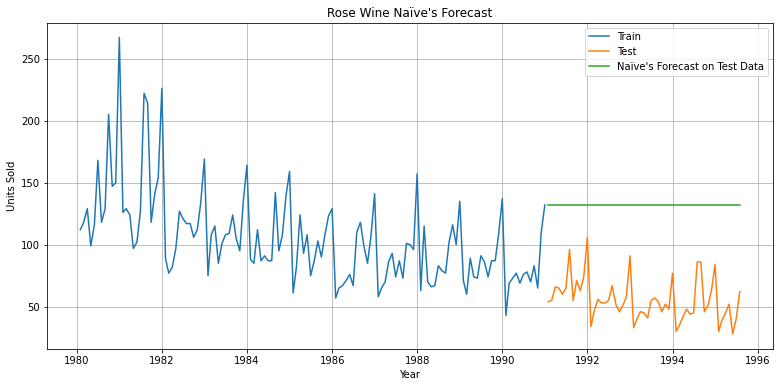

In [68]:
plt.plot(NaiveModel_train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.title("Rose Wine Sales - Naïve's Approach Model")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.plot(NaiveModel_test['naive'], label="Naïve's Forecast on Test Data")
plt.legend(loc='best')
plt.title("Rose Wine Naïve's Forecast")
plt.grid();

### Test Data - RMSE

In [69]:
rmse_model2_test = metrics.mean_squared_error(test['Rose'],NaiveModel_test['naive'],squared=False)
print("For Naïve's forecast on the Test Data, RMSE is %3.3f" %(rmse_model2_test))

For Naïve's forecast on the Test Data, RMSE is 78.485


In [70]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [rmse_model2_test]},index=["Naïve's Model"])
resultsDf = pd.concat([resultsDf, resultsDf_2])
round(resultsDf,2)

Test RMSE
RegressionOnTime      50.57
Naïve's Model         78.49

### Model 3: Simple Average

In [71]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [72]:
SimpleAverage_test['mean_forecast'] = train['Rose'].mean()
SimpleAverage_test.head()

Rose  mean_forecast
Time_Stamp                     
1991-01-31  54.0     104.939394
1991-02-28  55.0     104.939394
1991-03-31  66.0     104.939394
1991-04-30  65.0     104.939394
1991-05-31  60.0     104.939394

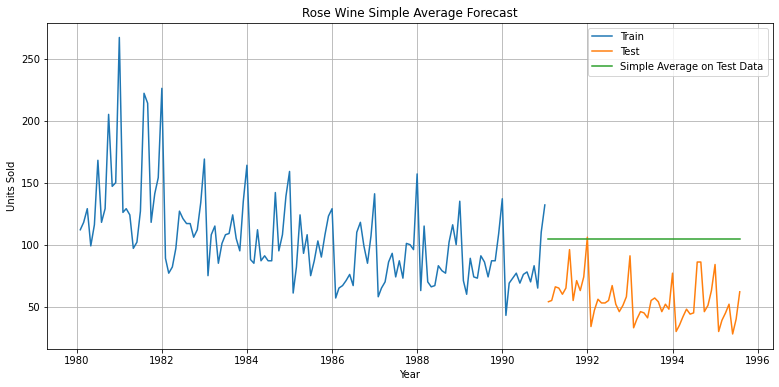

In [73]:
plt.plot(SimpleAverage_train['Rose'], label='Train')
plt.plot(SimpleAverage_test['Rose'], label='Test')
plt.title("Rose Wine Sales - Simple Average Model")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Rose Wine Simple Average Forecast")
plt.grid();

### Test Data - RMSE

In [74]:
rmse_model3_test = metrics.mean_squared_error(test['Rose'],SimpleAverage_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data, RMSE is %3.3f" %(rmse_model3_test))

For Simple Average forecast on the Test Data, RMSE is 52.370


In [75]:
resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test]},index=['SimpleAverageModel'])
resultsDf = pd.concat([resultsDf, resultsDf_3])
round(resultsDf,2)

Test RMSE
RegressionOnTime        50.57
Naïve's Model           78.49
SimpleAverageModel      52.37

### Model 4: Moving Average

In [76]:
MovingAverage = ds.copy()
MovingAverage.head()

Rose
Time_Stamp       
1980-01-31  112.0
1980-02-29  118.0
1980-03-31  129.0
1980-04-30   99.0
1980-05-31  116.0

In [77]:
MovingAverage['Trailing_2'] = MovingAverage['Rose'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Rose'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Rose'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Rose'].rolling(9).mean()
MovingAverage.head()

Rose  Trailing_2  Trailing_4  Trailing_6  Trailing_9
Time_Stamp                                                       
1980-01-31  112.0         NaN         NaN         NaN         NaN
1980-02-29  118.0       115.0         NaN         NaN         NaN
1980-03-31  129.0       123.5         NaN         NaN         NaN
1980-04-30   99.0       114.0       114.5         NaN         NaN
1980-05-31  116.0       107.5       115.5         NaN         NaN

### Plotting on the whole data

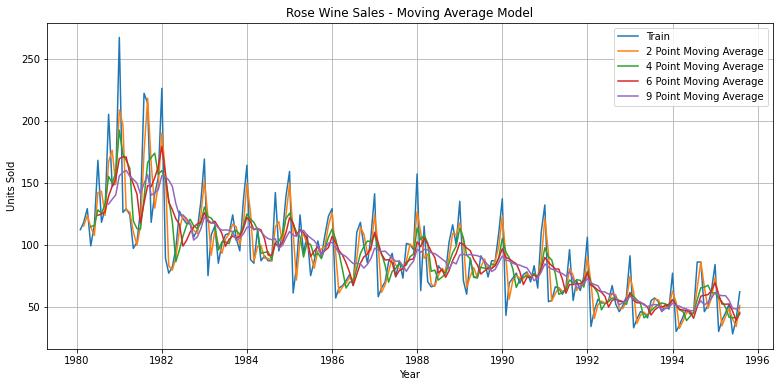

In [78]:
plt.plot(MovingAverage['Rose'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')
plt.title("Rose Wine Sales - Moving Average Model")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend(loc = 'best')
plt.grid();

### Creating train and test set

In [79]:
trailing_MovingAverage_train=MovingAverage[ds.index.year< 1991]
trailing_MovingAverage_test=MovingAverage[ds.index.year>=1991]

### Plotting on both the Training and Test data

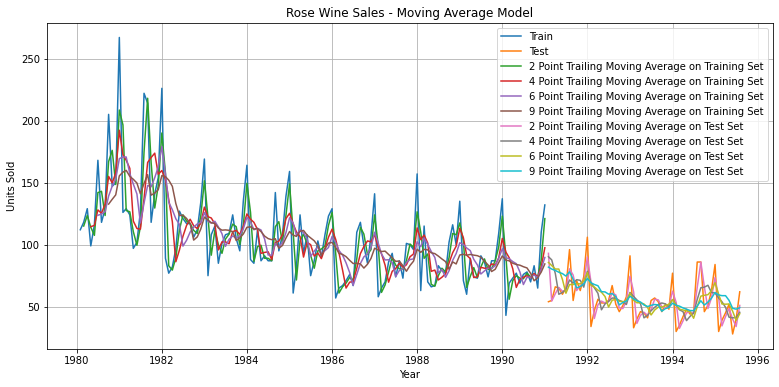

In [80]:
plt.plot(trailing_MovingAverage_train['Rose'], label='Train')
plt.plot(trailing_MovingAverage_test['Rose'], label='Test')
plt.plot(trailing_MovingAverage_train['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.title("Rose Wine Sales - Moving Average Model")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.grid();

In [81]:
# Test Data - RMSE --> 2 point Trailing MA
rmse_model4_test2 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,RMSE is %3.3f" %(rmse_model4_test2))
# Test Data - RMSE --> 4 point Trailing MA
rmse_model4_test4 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,RMSE is %3.3f" %(rmse_model4_test4))
# Test Data - RMSE --> 6 point Trailing MA
rmse_model4_test6 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,RMSE is %3.3f" %(rmse_model4_test6))
## Test Data - RMSE --> 9 point Trailing MA
rmse_model4_test9 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,RMSE is %3.3f " %(rmse_model4_test9))

For 2 point Moving Average Model forecast on the Training Data,RMSE is 12.159
For 4 point Moving Average Model forecast on the Training Data,RMSE is 15.572
For 6 point Moving Average Model forecast on the Training Data,RMSE is 15.687
For 9 point Moving Average Model forecast on the Training Data,RMSE is 16.161 


In [82]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test2,rmse_model4_test4,rmse_model4_test6,rmse_model4_test9]}
,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage','6pointTrailingMovingAverage','9pointTrailingMovingAverage'])
resultsDf = pd.concat([resultsDf, resultsDf_4])
round(resultsDf,2)

Test RMSE
RegressionOnTime                 50.57
Naïve's Model                    78.49
SimpleAverageModel               52.37
2pointTrailingMovingAverage      12.16
4pointTrailingMovingAverage      15.57
6pointTrailingMovingAverage      15.69
9pointTrailingMovingAverage      16.16

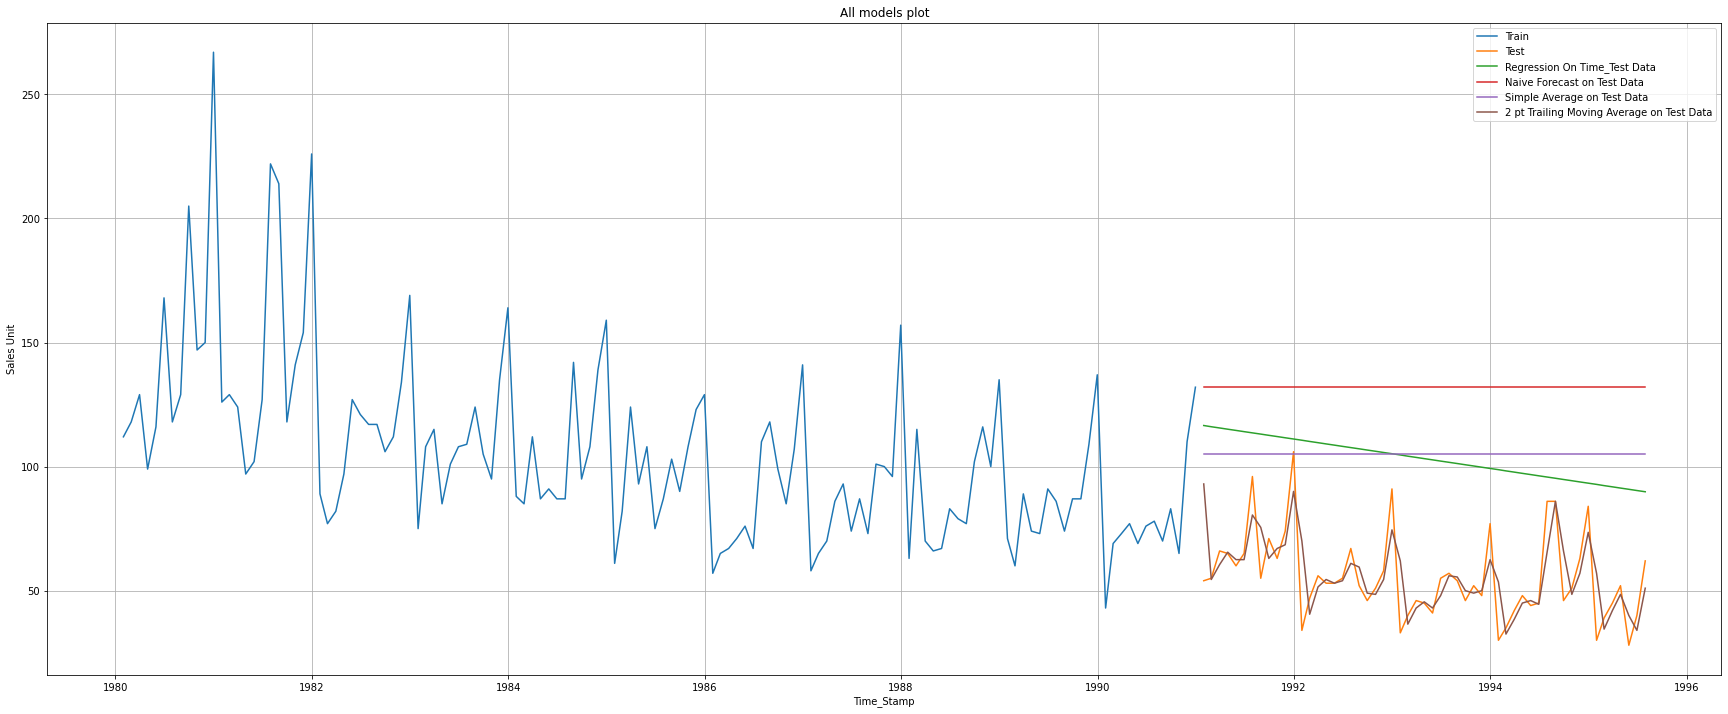

In [83]:
plt.figure(figsize=(30,12))
plt.plot(train['Rose'],label='Train')
plt.plot(test['Rose'],label='Test')
plt.plot(LinearRegression_test['RegOnTime'],label='Regression On Time_Test Data')
plt.plot(NaiveModel_test['naive'],label='Naive Forecast on Test Data')
plt.plot(SimpleAverage_test['mean_forecast'],label='Simple Average on Test Data')
plt.plot(trailing_MovingAverage_test['Trailing_2'],label='2 pt Trailing Moving Average on Test Data')
plt.legend(loc='best')
plt.title('All models plot')
plt.ylabel("Sales Unit")
plt.xlabel("Time_Stamp")
plt.grid();

### Model 5: Simple Exponential Smoothing

In [84]:
SES_train = train.copy()
SES_test = test.copy()

In [85]:
model_SES = SimpleExpSmoothing(SES_train['Rose'])

In [86]:
model_SES_autofit = model_SES.fit(optimized=True)

In [87]:
model_SES_autofit.params

{'smoothing_level': 0.0987493111726833,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.38720226208358,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [88]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

Rose    predict
Time_Stamp                 
1991-01-31  54.0  87.104983
1991-02-28  55.0  87.104983
1991-03-31  66.0  87.104983
1991-04-30  65.0  87.104983
1991-05-31  60.0  87.104983

### Plotting on both the Training and Test data

Text(0, 0.5, 'Units Sold')

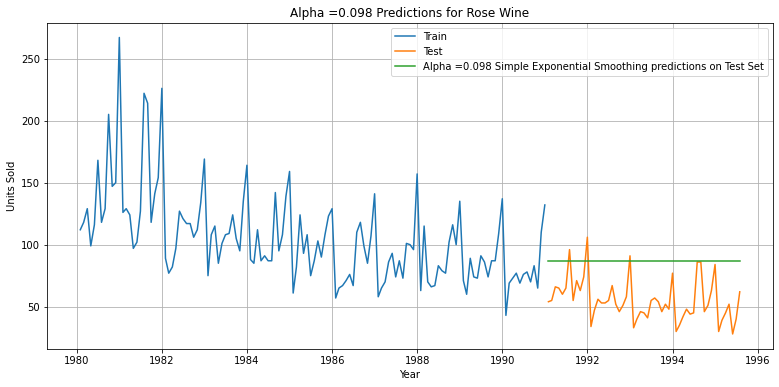

In [89]:
plt.plot(SES_train['Rose'], label='Train')
plt.plot(SES_test['Rose'], label='Test')
plt.plot(SES_test['predict'], label='Alpha =0.098 Simple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.098 Predictions for Rose Wine');
plt.xlabel('Year')
plt.ylabel('Units Sold')

### Test Data

In [90]:
rmse_model5_test_1 = metrics.mean_squared_error(SES_test['Rose'],SES_test['predict'],squared=False)
print("For Alpha = 0.098 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model5_test_1))

For Alpha = 0.098 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 35.931


In [91]:
resultsDf_5 = pd.DataFrame({'Test RMSE': [rmse_model5_test_1]},index=['Alpha=0.098,SimpleExponentialSmoothing'])
resultsDf = pd.concat([resultsDf, resultsDf_5])
round(resultsDf,2)

Test RMSE
RegressionOnTime                            50.57
Naïve's Model                               78.49
SimpleAverageModel                          52.37
2pointTrailingMovingAverage                 12.16
4pointTrailingMovingAverage                 15.57
6pointTrailingMovingAverage                 15.69
9pointTrailingMovingAverage                 16.16
Alpha=0.098,SimpleExponentialSmoothing      35.93

### First we will define an empty dataframe to store our values from the loop

In [92]:
resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
round(resultsDf_6,2)

Empty DataFrame
Columns: [Alpha Values, Train RMSE, Test RMSE]
Index: []

In [93]:
for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=len(test))
    rmse_model5_train_i = metrics.mean_squared_error(SES_train['Rose'],SES_train['predict',i],squared=False)
    rmse_model5_test_i = metrics.mean_squared_error(SES_test['Rose'],SES_test['predict',i],squared=False)
    resultsDf_6 = resultsDf_6.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i,'Test RMSE':rmse_model5_test_i},ignore_index=True)

In [94]:
round(resultsDf_6,2).sort_values(by=['Test RMSE'],ascending=True)

Alpha Values  Train RMSE  Test RMSE
0           0.3       32.47      46.47
1           0.4       33.04      52.67
2           0.5       33.68      58.50
3           0.6       34.44      63.80
4           0.7       35.32      68.50
5           0.8       36.33      72.56
6           0.9       37.48      75.91

### Plotting on both the Training and Test data

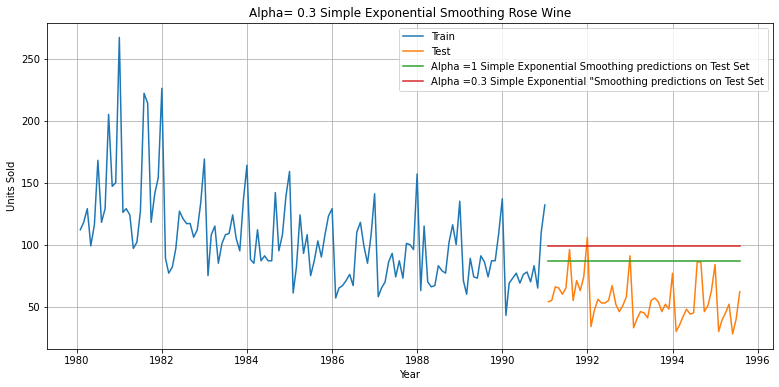

In [95]:
plt.plot(SES_train['Rose'], label='Train')
plt.plot(SES_test['Rose'], label='Test')
plt.plot(SES_test['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Test Set')
plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 Simple Exponential "Smoothing predictions on Test Set')
plt.title("Alpha= 0.3 Simple Exponential Smoothing Rose Wine")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend(loc='best')
plt.grid();

In [96]:
resultsDf_6_1 = pd.DataFrame({'Test RMSE': [resultsDf_6.sort_values(by=['Test RMSE'],ascending=True).values[0][2]]},index=['Alpha=0.3,SimpleExponentialSmoothing'])
resultsDf = pd.concat([resultsDf, resultsDf_6_1])
round(resultsDf,2)

Test RMSE
RegressionOnTime                            50.57
Naïve's Model                               78.49
SimpleAverageModel                          52.37
2pointTrailingMovingAverage                 12.16
4pointTrailingMovingAverage                 15.57
6pointTrailingMovingAverage                 15.69
9pointTrailingMovingAverage                 16.16
Alpha=0.098,SimpleExponentialSmoothing      35.93
Alpha=0.3,SimpleExponentialSmoothing        46.47

### Model 6: Double Exponential Smoothing - Holt's Model

In [97]:
DES_train = train.copy()
DES_test = test.copy()

In [98]:
model_DES = Holt(DES_train['Rose'])

### First we will define an empty dataframe to store our values from the loop

In [99]:
resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
round(resultsDf_7,2)

Empty DataFrame
Columns: [Alpha Values, Beta Values, Train RMSE, Test RMSE]
Index: []

In [100]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=len(test))
        rmse_model6_train = metrics.mean_squared_error(DES_train['Rose'],DES_train['predict',i,j],squared=False)
        rmse_model6_test = metrics.mean_squared_error(DES_test['Rose'],DES_test['predict',i,j],squared=False)
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model6_train,'Test RMSE':rmse_model6_test}, ignore_index=True)

In [101]:
round(resultsDf_7,2)

Alpha Values  Beta Values  Train RMSE  Test RMSE
0            0.3          0.1       33.61      97.05
1            0.3          0.2       34.65     175.35
2            0.3          0.3       35.94     263.71
3            0.3          0.4       37.39     356.86
4            0.3          0.5       38.89     449.90
..           ...          ...         ...        ...
75           1.0          0.6       51.83     799.74
76           1.0          0.7       54.50     839.95
77           1.0          0.8       57.37     852.03
78           1.0          0.9       60.47     832.77
79           1.0          1.0       63.87     778.15

[80 rows x 4 columns]

In [102]:
round(resultsDf_7,2).sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values  Train RMSE  Test RMSE
0            0.3          0.1       33.61      97.05
10           0.4          0.1       34.26     127.30
20           0.5          0.1       34.96     153.64
1            0.3          0.2       34.65     175.35
30           0.6          0.1       35.78     176.26

### Plotting on both the Training and Test data

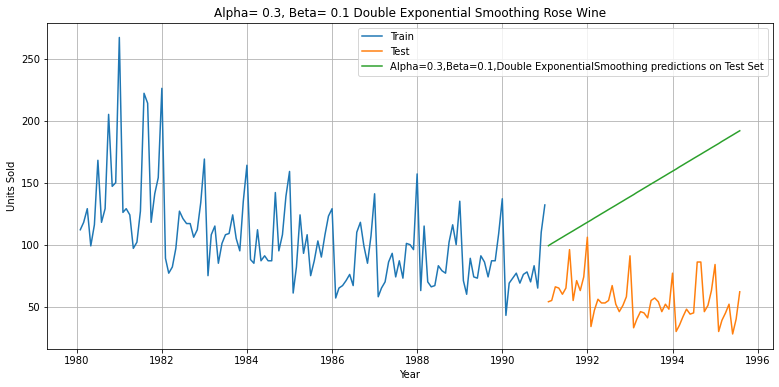

In [103]:
plt.plot(DES_train['Rose'], label='Train')
plt.plot(DES_test['Rose'], label='Test')
plt.plot(DES_test['predict', 0.3, 0.1], label='Alpha=0.3,Beta=0.1,Double ExponentialSmoothing predictions on Test Set')
plt.title("Alpha= 0.3, Beta= 0.1 Double Exponential Smoothing Rose Wine")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend(loc='best')
plt.grid();

In [104]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]]},index=['Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing'])
resultsDf = pd.concat([resultsDf, resultsDf_7_1])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                   50.57
Naïve's Model                                      78.49
SimpleAverageModel                                 52.37
2pointTrailingMovingAverage                        12.16
4pointTrailingMovingAverage                        15.57
6pointTrailingMovingAverage                        15.69
9pointTrailingMovingAverage                        16.16
Alpha=0.098,SimpleExponentialSmoothing             35.93
Alpha=0.3,SimpleExponentialSmoothing               46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing      97.05

### Model 7: Triple Exponential Smoothing - Holt Winter's Model

In [105]:
TES_train = train.copy()
TES_test = test.copy()

In [106]:
model_TES = ExponentialSmoothing(TES_train['Rose'],trend='additive',seasonal='multiplicative',freq='M')

In [107]:
model_TES_autofit = model_TES.fit()

In [108]:
model_TES_autofit.params

{'smoothing_level': 0.06569374607191865,
 'smoothing_trend': 0.05192938504457338,
 'smoothing_seasonal': 3.879136202038614e-06,
 'damping_trend': nan,
 'initial_level': 54.10985491750761,
 'initial_trend': -0.33471965714896845,
 'initial_seasons': array([2.08282313, 2.36326666, 2.58210206, 2.25702695, 2.53757493,
        2.76639991, 3.04101803, 3.23434567, 3.06747277, 3.00164124,
        3.49893806, 4.82552476]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Prediction on the test data

In [109]:
TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))
TES_test.head()

Rose  auto_predict
Time_Stamp                    
1991-01-31  54.0     56.689174
1991-02-28  55.0     64.129166
1991-03-31  66.0     69.856436
1991-04-30  65.0     60.877474
1991-05-31  60.0     68.237072

### Plotting on both the Training and Test using autofit

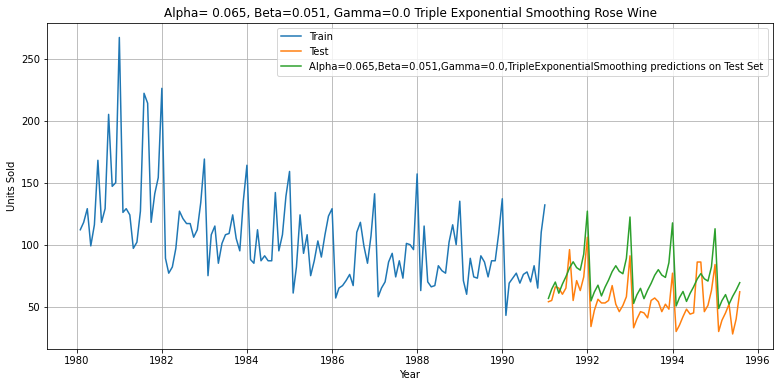

In [110]:
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')
plt.plot(TES_test['auto_predict'], label='Alpha=0.065,Beta=0.051,Gamma=0.0,TripleExponentialSmoothing predictions on Test Set')
plt.title("Alpha= 0.065, Beta=0.051, Gamma=0.0 Triple Exponential Smoothing Rose Wine")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend(loc='best')
plt.grid();

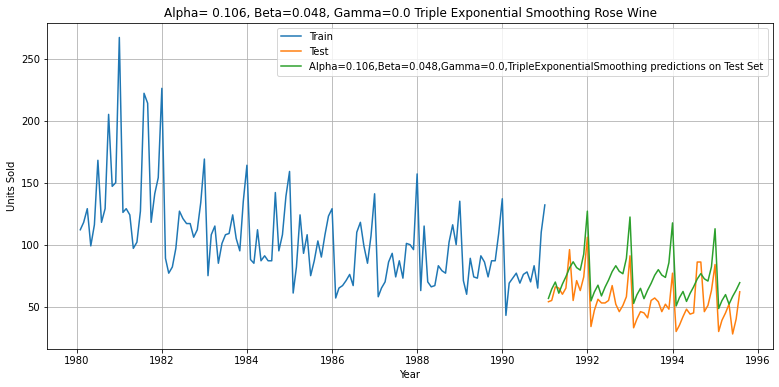

In [111]:
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')
plt.plot(TES_test['auto_predict'], label='Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponentialSmoothing predictions on Test Set')
plt.title("Alpha= 0.106, Beta=0.048, Gamma=0.0 Triple Exponential Smoothing Rose Wine")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend(loc='best')
plt.grid();

### Test Data

In [112]:
rmse_model6_test_1 = metrics.mean_squared_error(TES_test['Rose'],TES_test['auto_predict'],squared=False)
print("For Alpha=0.106,Beta=0.048,Gamma=0.0, Triple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model6_test_1))

For Alpha=0.106,Beta=0.048,Gamma=0.0, Triple Exponential Smoothing Model forecast on the Test Data, RMSE is 20.398


In [113]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]},index=['Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponentialSmoothing'])
resultsDf = pd.concat([resultsDf, resultsDf_8_1])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                        50.57
Naïve's Model                                           78.49
SimpleAverageModel                                      52.37
2pointTrailingMovingAverage                             12.16
4pointTrailingMovingAverage                             15.57
6pointTrailingMovingAverage                             15.69
9pointTrailingMovingAverage                             16.16
Alpha=0.098,SimpleExponentialSmoothing                  35.93
Alpha=0.3,SimpleExponentialSmoothing                    46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing           97.05
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...      20.40

### First we will define an empty dataframe to store our values from the loop

In [114]:
resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_8_2

Empty DataFrame
Columns: [Alpha Values, Beta Values, Gamma Values, Train RMSE, Test RMSE]
Index: []

In [115]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_slope=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=len(test))
            rmse_model8_train = metrics.mean_squared_error(TES_train['Rose'],TES_train['predict',i,j,k],squared=False)
            rmse_model8_test = metrics.mean_squared_error(TES_test['Rose'],TES_test['predict',i,j,k],squared=False)
            resultsDf_8_2 = resultsDf_8_2.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,'Train RMSE':rmse_model8_train,'Test RMSE':rmse_model8_test}, ignore_index=True)

In [116]:
resultsDf_8_2=resultsDf_8_2.sort_values(by=['Test RMSE']).head()
round(resultsDf_8_2,2)

Alpha Values  Beta Values  Gamma Values  Train RMSE  Test RMSE
8            0.3          0.4           0.3       28.11      13.01
1            0.3          0.3           0.4       27.40      14.61
69           0.4          0.3           0.8       32.60      14.91
16           0.3          0.5           0.3       29.09      17.64
0            0.3          0.3           0.3       27.22      19.23

### Plotting on both the Training and Test data using brute force alpha,beta and gamma determination

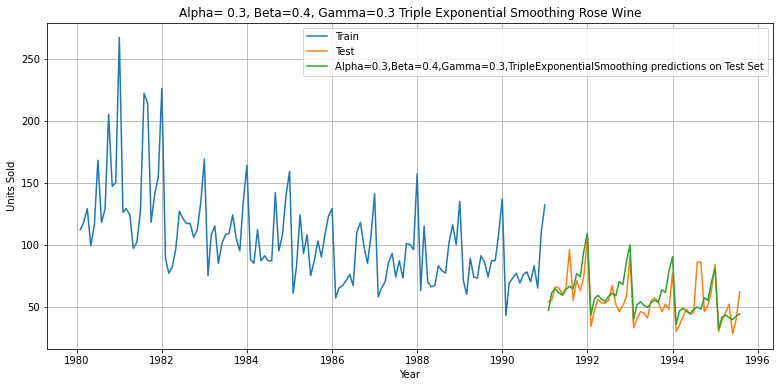

In [117]:
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')
#The value of alpha and beta is taken like that by python
plt.plot(TES_test['predict', 0.3, 0.4, 0.3], label='Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')
plt.title("Alpha= 0.3, Beta=0.4, Gamma=0.3 Triple Exponential Smoothing Rose Wine")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend(loc='best')
plt.grid();

In [118]:
resultsDf_8_3 = pd.DataFrame({'Test RMSE': [resultsDf_8_2.sort_values(by=['Test RMSE']).values[0][4]]},index=['Alpha=0.3,Beta=0.4,Gamma=0.3,Triple ExponentialSmoothing'])
resultsDf = pd.concat([resultsDf, resultsDf_8_3])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                        50.57
Naïve's Model                                           78.49
SimpleAverageModel                                      52.37
2pointTrailingMovingAverage                             12.16
4pointTrailingMovingAverage                             15.57
6pointTrailingMovingAverage                             15.69
9pointTrailingMovingAverage                             16.16
Alpha=0.098,SimpleExponentialSmoothing                  35.93
Alpha=0.3,SimpleExponentialSmoothing                    46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing           97.05
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...      20.40
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...      13.01

# 5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

### Test for stationarity of the series - Dicky Fuller test

In [119]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std() #determining the rolling standard deviation
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation For Rose Wine Production')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput,'\n')

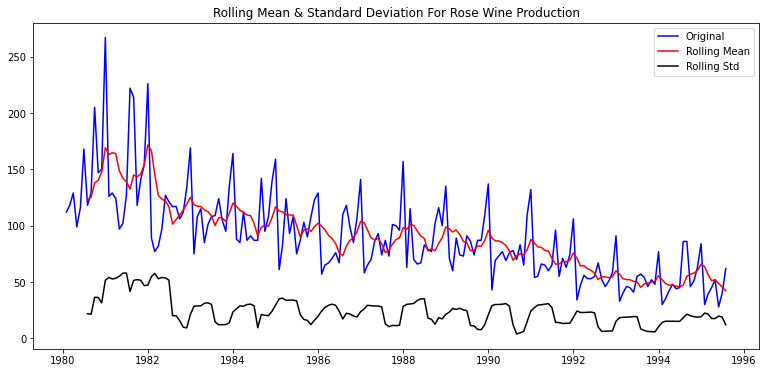

Results of Dickey-Fuller Test:
Test Statistic                  -1.933053
p-value                          0.316675
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
dtype: float64 

Test Statistic                  -1.933053
p-value                          0.316675
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
dtype: float64 

Test Statistic                  -1.933053
p-value                          0.316675
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 



In [120]:
test_stationarity(ds['Rose'])

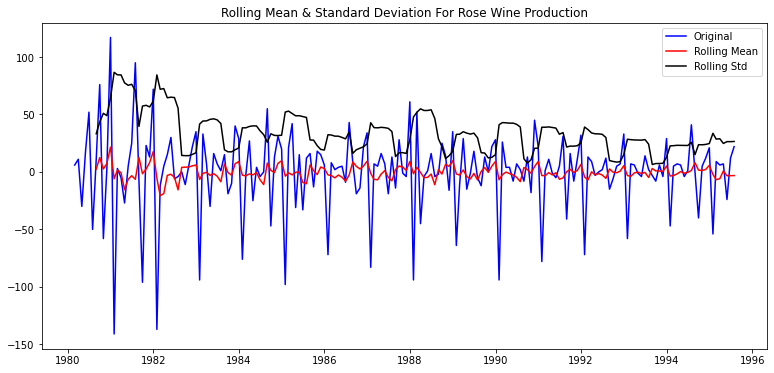

Results of Dickey-Fuller Test:
Test Statistic                -7.890753e+00
p-value                        4.443288e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
dtype: float64 

Test Statistic                -7.890753e+00
p-value                        4.443288e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
dtype: float64 

Test Statistic                -7.890753e+00
p-value                        4.443288e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64 



In [121]:
test_stationarity(ds['Rose'].diff().dropna())

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1980-01-31 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


# 6. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

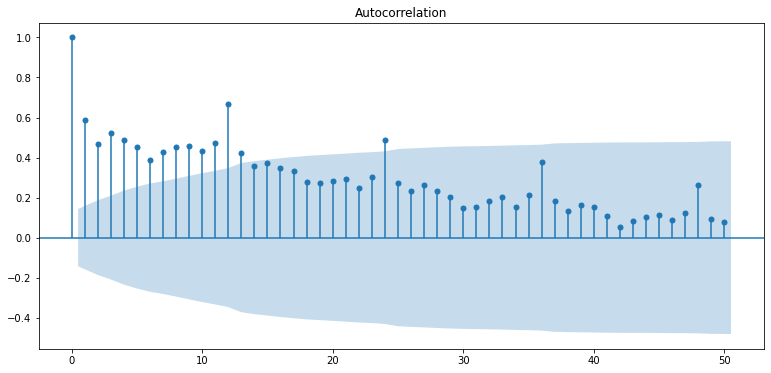

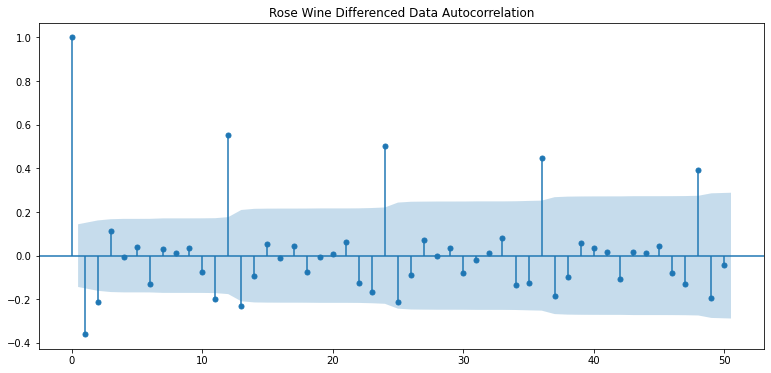

In [123]:
plot_acf(ds['Rose'],lags=50)
plot_acf(ds['Rose'].diff().dropna(),lags=50,title='Rose Wine Differenced Data Autocorrelation')
plt.show()

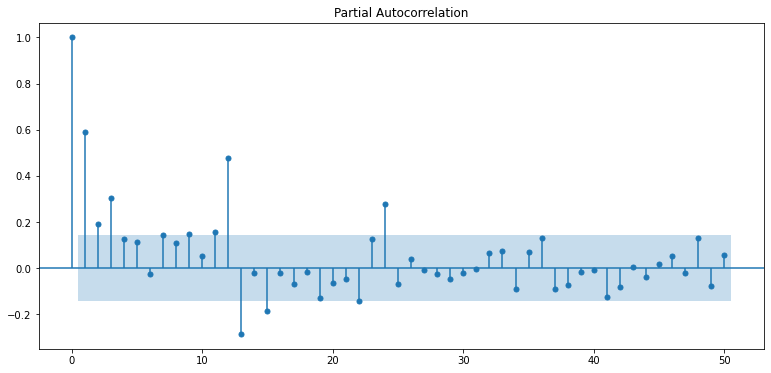

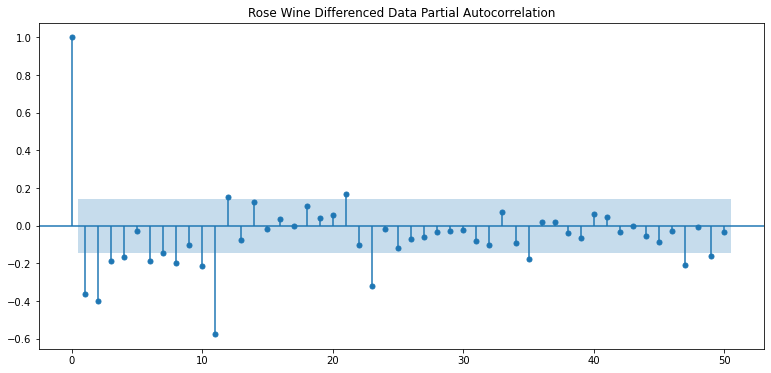

In [124]:
plot_pacf(ds['Rose'],lags=50)
plot_pacf(ds['Rose'].diff().dropna(),lags=50,title='Rose Wine Differenced Data Partial Autocorrelation')
plt.show()

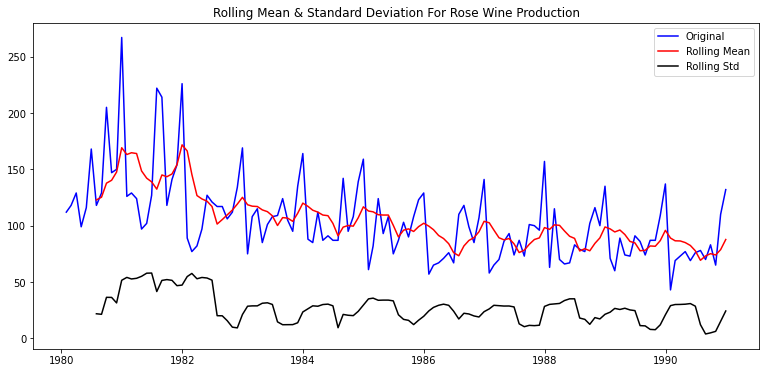

Results of Dickey-Fuller Test:
Test Statistic                  -2.164250
p-value                          0.219476
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
dtype: float64 

Test Statistic                  -2.164250
p-value                          0.219476
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
dtype: float64 

Test Statistic                  -2.164250
p-value                          0.219476
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64 



In [125]:
test_stationarity(train['Rose'])

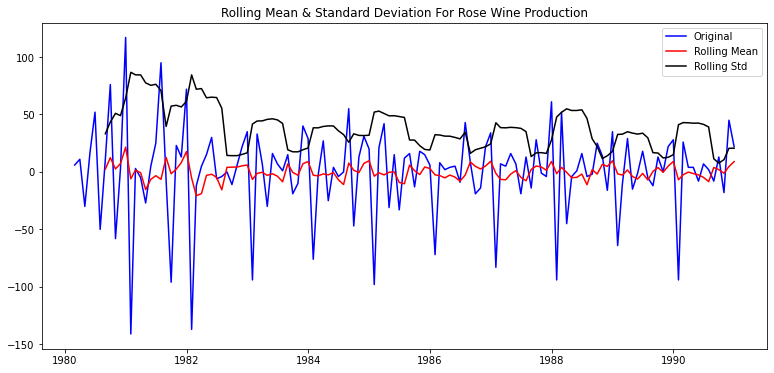

Results of Dickey-Fuller Test:
Test Statistic                -6.592372e+00
p-value                        7.061944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
dtype: float64 

Test Statistic                -6.592372e+00
p-value                        7.061944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
dtype: float64 

Test Statistic                -6.592372e+00
p-value                        7.061944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64 



In [126]:
test_stationarity(train['Rose'].diff().dropna())

### Automated ARIMA Model

In [127]:
p = q = range(0, 3)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


### Creating an empty Dataframe with column names only

In [128]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

Empty DataFrame
Columns: [param, AIC]
Index: []

In [129]:
for param in pdq:
    ARIMA_model = ARIMA(train['Rose'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:1335.1526583086775
ARIMA(0, 1, 1) - AIC:1280.726183046448
ARIMA(0, 1, 2) - AIC:1276.8353734911866
ARIMA(1, 1, 0) - AIC:1319.3483105802602
ARIMA(1, 1, 1) - AIC:1277.7757532785026
ARIMA(1, 1, 2) - AIC:1277.359228683666
ARIMA(2, 1, 0) - AIC:1300.6092611744193
ARIMA(2, 1, 1) - AIC:1279.045689409317
ARIMA(2, 1, 2) - AIC:1279.298693936495


### Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

In [130]:
ARIMA_AIC.sort_values(by='AIC',ascending=True)

param          AIC
2  (0, 1, 2)  1276.835373
5  (1, 1, 2)  1277.359229
4  (1, 1, 1)  1277.775753
7  (2, 1, 1)  1279.045689
8  (2, 1, 2)  1279.298694
1  (0, 1, 1)  1280.726183
6  (2, 1, 0)  1300.609261
3  (1, 1, 0)  1319.348311
0  (0, 1, 0)  1335.152658

In [131]:
auto_ARIMA = ARIMA(train['Rose'], order=(0,1,2),freq='M')
results_auto_ARIMA = auto_ARIMA.fit()
print(results_auto_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rose   No. Observations:                  131
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -634.418
Method:                       css-mle   S.D. of innovations             30.167
Date:                Tue, 12 Jul 2022   AIC                           1276.835
Time:                        22:27:27   BIC                           1288.336
Sample:                    02-29-1980   HQIC                          1281.509
                         - 12-31-1990                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4886      0.085     -5.742      0.000      -0.655      -0.322
ma.L1.D.Rose    -0.7601      0.101     -7.499      0.000      -0.959      -0.561
ma.L2.D.Rose    -0.2398      0.095     -2.51

In [132]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

In [133]:
rmse = mean_squared_error(test['Rose'],predicted_auto_ARIMA[0],squared=False)
print(rmse)

16.933990576489403


In [134]:
resultsDf_9 = pd.DataFrame({'Test RMSE': [rmse]},index=['ARIMA(0,1,2)'])
round(resultsDf_9,3)

Test RMSE
ARIMA(0,1,2)     16.934

In [135]:
resultsDf_9 = pd.DataFrame({'Test RMSE': [rmse]},index=['ARIMA(0,1,2)'])
resultsDf = pd.concat([resultsDf, resultsDf_9])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                        50.57
Naïve's Model                                           78.49
SimpleAverageModel                                      52.37
2pointTrailingMovingAverage                             12.16
4pointTrailingMovingAverage                             15.57
6pointTrailingMovingAverage                             15.69
9pointTrailingMovingAverage                             16.16
Alpha=0.098,SimpleExponentialSmoothing                  35.93
Alpha=0.3,SimpleExponentialSmoothing                    46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing           97.05
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...      20.40
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...      13.01
ARIMA(0,1,2)                                            16.93

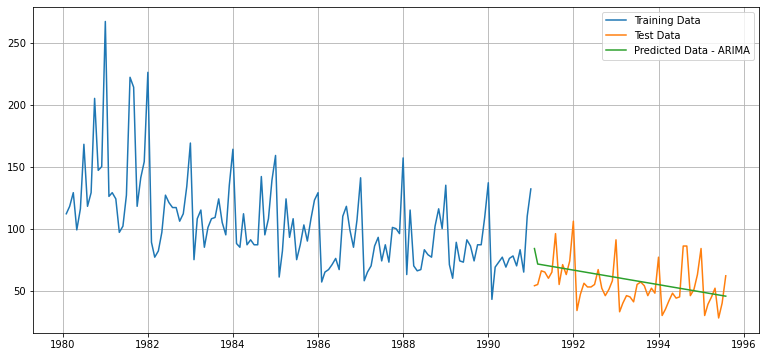

In [136]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,predicted_auto_ARIMA[0],label='Predicted Data - ARIMA')
plt.legend(loc='best')
plt.grid();

### Automated SARIMA Model

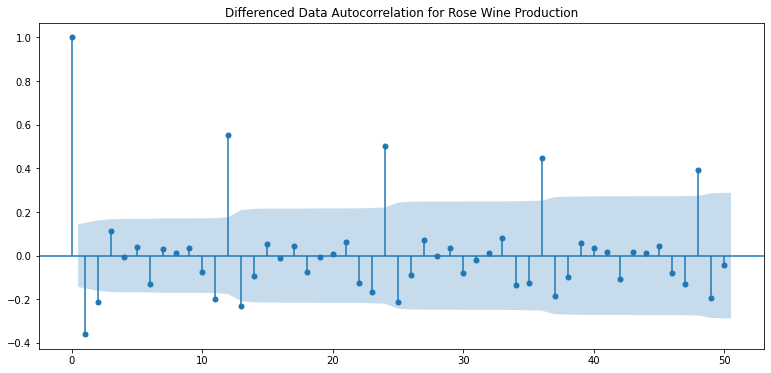

In [137]:
plot_acf(ds['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation for Rose Wine Production')
plt.show()

### Setting the seasonality as 6 for the first iteration of the auto SARIMA model

#### We see that there can be a seasonality of 6 as well as 12. We will run our auto SARIMA models by setting seasonality both as 6 and 12.

### Setting the seasonality as 6 for the first iteration of the auto SARIMA model.

In [138]:
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 6)
Model: (0, 1, 2)(0, 0, 2, 6)
Model: (1, 1, 0)(1, 0, 0, 6)
Model: (1, 1, 1)(1, 0, 1, 6)
Model: (1, 1, 2)(1, 0, 2, 6)
Model: (2, 1, 0)(2, 0, 0, 6)
Model: (2, 1, 1)(2, 0, 1, 6)
Model: (2, 1, 2)(2, 0, 2, 6)


In [139]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [140]:
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Rose'].values,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))

SARIMA(0, 1, 0)x(0, 0, 0, 6) - AIC:1323.9657875279158
SARIMA(0, 1, 0)x(0, 0, 1, 6) - AIC:1264.499626111386
SARIMA(0, 1, 0)x(0, 0, 2, 6) - AIC:1144.707747182699
SARIMA(0, 1, 0)x(1, 0, 0, 6) - AIC:1274.7897737087985
SARIMA(0, 1, 0)x(1, 0, 1, 6) - AIC:1241.7870945149016
SARIMA(0, 1, 0)x(1, 0, 2, 6) - AIC:1146.3093266721783
SARIMA(0, 1, 0)x(2, 0, 0, 6) - AIC:1137.9167236212038
SARIMA(0, 1, 0)x(2, 0, 1, 6) - AIC:1137.4533629515017
SARIMA(0, 1, 0)x(2, 0, 2, 6) - AIC:1117.0224426205107
SARIMA(0, 1, 1)x(0, 0, 0, 6) - AIC:1263.5369097383964
SARIMA(0, 1, 1)x(0, 0, 1, 6) - AIC:1201.3832548029548
SARIMA(0, 1, 1)x(0, 0, 2, 6) - AIC:1097.1908217752784
SARIMA(0, 1, 1)x(1, 0, 0, 6) - AIC:1222.4354735745055
SARIMA(0, 1, 1)x(1, 0, 1, 6) - AIC:1160.4386253746306
SARIMA(0, 1, 1)x(1, 0, 2, 6) - AIC:1084.8564123384424
SARIMA(0, 1, 1)x(2, 0, 0, 6) - AIC:1095.7490379982505
SARIMA(0, 1, 1)x(2, 0, 1, 6) - AIC:1097.645518931348
SARIMA(0, 1, 1)x(2, 0, 2, 6) - AIC:1053.0044082623185
SARIMA(0, 1, 2)x(0, 0, 0, 6) - 

In [141]:
SARIMA_AIC.sort_values(by=['AIC']).head()

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [142]:
auto_SARIMA_6 = sm.tsa.statespace.SARIMAX(train['Rose'].values,order=(1, 1, 2),seasonal_order=(2, 0, 2, 6),enforce_stationarity=False,enforce_invertibility=False)
results_auto_SARIMA_6 = auto_SARIMA_6.fit(maxiter=1000)
print(results_auto_SARIMA_6.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 6)   Log Likelihood                -512.828
Date:                           Tue, 12 Jul 2022   AIC                           1041.656
Time:                                   22:28:20   BIC                           1063.685
Sample:                                        0   HQIC                          1050.598
                                           - 132                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5940      0.152     -3.900      0.000      -0.892      -0.295
ma.L1         -0.1954    939.337     -0.000

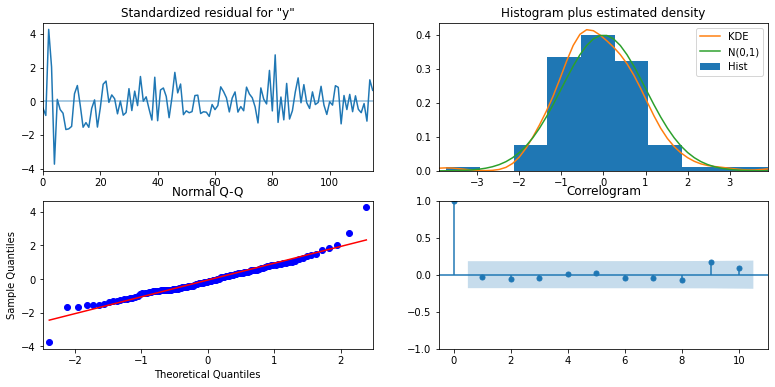

In [143]:
results_auto_SARIMA_6.plot_diagnostics()
plt.show()

In [144]:
predicted_auto_SARIMA_6 = results_auto_SARIMA_6.get_forecast(steps=len(test))

In [145]:
predicted_auto_SARIMA_6.summary_frame(alpha=0.05).head()

y       mean    mean_se  mean_ci_lower  mean_ci_upper
0  62.841321  18.848407      25.899122      99.783521
1  67.630796  19.300206      29.803087     105.458505
2  74.746981  19.412775      36.698642     112.795320
3  71.325991  19.475732      33.154258     109.497724
4  76.018250  19.484015      37.830281     114.206218

In [146]:
rmse = mean_squared_error(test['Rose'],predicted_auto_SARIMA_6.predicted_mean,squared=False)
print(rmse)

25.283080969857284


In [147]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse]},index=['SARIMA(1,1,2)(2,0,2,6)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                        50.57
Naïve's Model                                           78.49
SimpleAverageModel                                      52.37
2pointTrailingMovingAverage                             12.16
4pointTrailingMovingAverage                             15.57
6pointTrailingMovingAverage                             15.69
9pointTrailingMovingAverage                             16.16
Alpha=0.098,SimpleExponentialSmoothing                  35.93
Alpha=0.3,SimpleExponentialSmoothing                    46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing           97.05
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...      20.40
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...      13.01
ARIMA(0,1,2)                                            16.93
SARIMA(1,1,2)(2,0,2,6)                                  25.28

### Setting the seasonality as 12 for the iteration of the auto SARIMA model

In [148]:
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)


In [149]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [150]:
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Rose'].values,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1323.9657875279158
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1145.423082720733
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:976.437529638088
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1139.921738995602
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1116.0207869386036
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:969.6913635753799
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:960.8812220353041
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:962.8794540697521
SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:955.5735408945577
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:1263.5369097383964
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1098.5554825918337
SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:923.6314049383789
SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1095.793632491795
SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1054.743433094527
SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:918.857348331104
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:914.5982866536075
SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:915.3332430461672
SARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:901.1988356729375
SARIMA(0, 1, 2)x(0, 0, 0, 

In [151]:
SARIMA_AIC.sort_values(by=['AIC']).head()

param       seasonal         AIC
26  (0, 1, 2)  (2, 0, 2, 12)  887.937509
53  (1, 1, 2)  (2, 0, 2, 12)  889.901686
80  (2, 1, 2)  (2, 0, 2, 12)  890.668798
69  (2, 1, 1)  (2, 0, 0, 12)  896.518161
78  (2, 1, 2)  (2, 0, 0, 12)  897.346444

In [152]:
auto_SARIMA_12 = sm.tsa.statespace.SARIMAX(train['Rose'].values,order=(0, 1, 2),seasonal_order=(2, 0, 2, 12),enforce_stationarity=False,enforce_invertibility=False)
results_auto_SARIMA_12 = auto_SARIMA_12.fit(maxiter=1000)
print(results_auto_SARIMA_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -436.969
Date:                            Tue, 12 Jul 2022   AIC                            887.938
Time:                                    22:29:38   BIC                            906.448
Sample:                                         0   HQIC                           895.437
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8427    189.778     -0.004      0.996    -372.800     371.115
ma.L2         -0.1573     29.815   

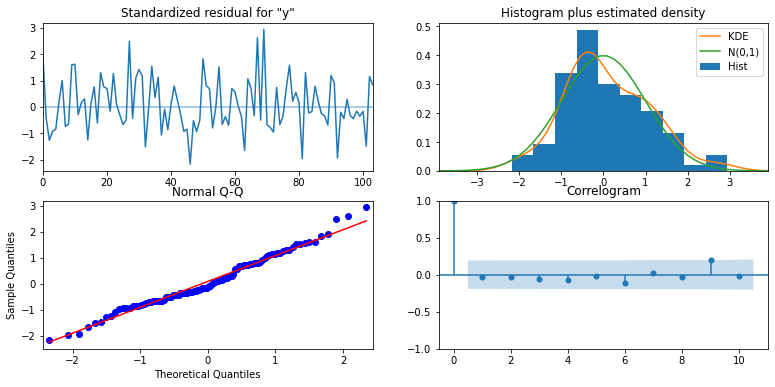

In [153]:
results_auto_SARIMA_12.plot_diagnostics()
plt.show()

In [154]:
predicted_auto_SARIMA_12 = results_auto_SARIMA_12.get_forecast(steps=len(test))

In [155]:
predicted_auto_SARIMA_12.summary_frame(alpha=0.05).head()

y       mean    mean_se  mean_ci_lower  mean_ci_upper
0  62.867263  15.928501      31.647976      94.086551
1  70.541190  16.147659      38.892360     102.190019
2  77.356410  16.147656      45.707586     109.005235
3  76.208814  16.147656      44.559989     107.857638
4  72.747398  16.147656      41.098573     104.396222

In [156]:
rmse = mean_squared_error(test['Rose'],predicted_auto_SARIMA_12.predicted_mean,squared=False)
print(rmse)

26.34525296686366


In [157]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse]},index=['SARIMA(0,1,2)(2,0,2,12)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                        50.57
Naïve's Model                                           78.49
SimpleAverageModel                                      52.37
2pointTrailingMovingAverage                             12.16
4pointTrailingMovingAverage                             15.57
6pointTrailingMovingAverage                             15.69
9pointTrailingMovingAverage                             16.16
Alpha=0.098,SimpleExponentialSmoothing                  35.93
Alpha=0.3,SimpleExponentialSmoothing                    46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing           97.05
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...      20.40
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...      13.01
ARIMA(0,1,2)                                            16.93
SARIMA(1,1,2)(2,0,2,6)                                  25.28
SARIMA(0,1,2)(2,0,2,12)                                 26.35

# 7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.

### Manual ARIMA

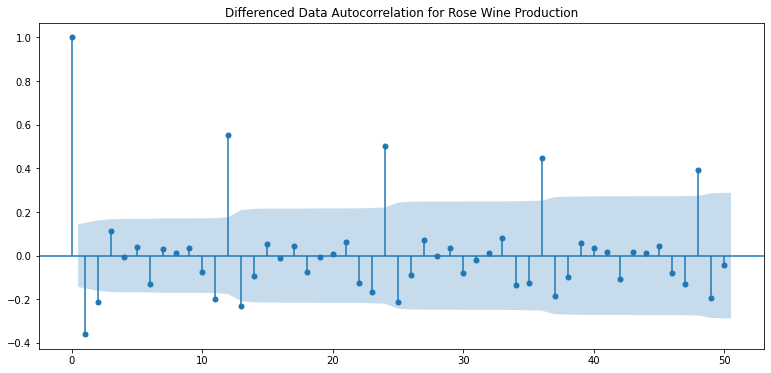

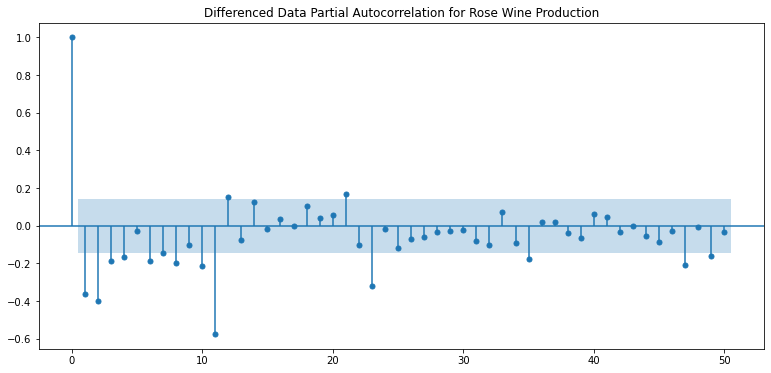

In [158]:
plot_acf(ds['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation for Rose Wine Production')
plot_pacf(ds['Rose'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation for Rose Wine Production')
plt.show()

In [159]:
manual_ARIMA = ARIMA(train['Rose'].astype('float64'), order=(3,1,2),freq='M')
results_manual_ARIMA = manual_ARIMA.fit()
print(results_manual_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rose   No. Observations:                  131
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -633.485
Method:                       css-mle   S.D. of innovations             29.948
Date:                Tue, 12 Jul 2022   AIC                           1280.969
Time:                        22:29:42   BIC                           1301.096
Sample:                    02-29-1980   HQIC                          1289.147
                         - 12-31-1990                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4883      0.085     -5.723      0.000      -0.655      -0.321
ar.L1.D.Rose    -0.3558      0.332     -1.071      0.284      -1.007       0.295
ar.L2.D.Rose     0.0279      0.120      0.23

In [160]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))

In [161]:
rmse = mean_squared_error(test['Rose'],predicted_manual_ARIMA[0],squared=False)
print(rmse)

16.847372358034175


In [162]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse]},index=['ARIMA(3,1,2)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

Test RMSE
RegressionOnTime                                    50.572900
Naïve's Model                                       78.485320
SimpleAverageModel                                  52.369847
2pointTrailingMovingAverage                         12.158798
4pointTrailingMovingAverage                         15.572375
6pointTrailingMovingAverage                         15.687446
9pointTrailingMovingAverage                         16.161176
Alpha=0.098,SimpleExponentialSmoothing              35.931340
Alpha=0.3,SimpleExponentialSmoothing                46.473062
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing       97.053293
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...  20.398003
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...  13.014696
ARIMA(0,1,2)                                        16.933991
SARIMA(1,1,2)(2,0,2,6)                              25.283081
SARIMA(0,1,2)(2,0,2,12)                             26.345253
ARIMA(3,1,2)                                        16.847372

### Manual SARIMA

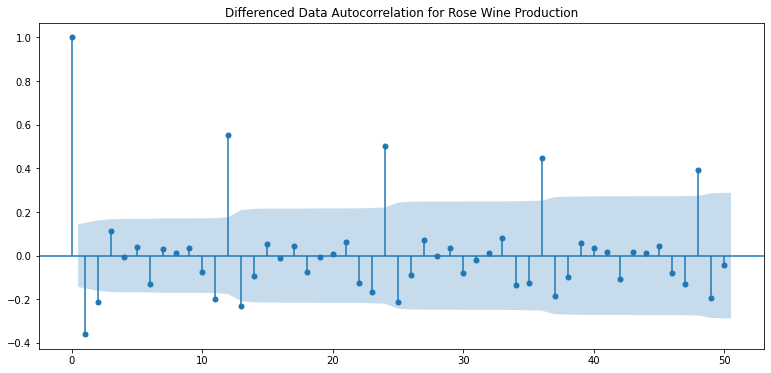

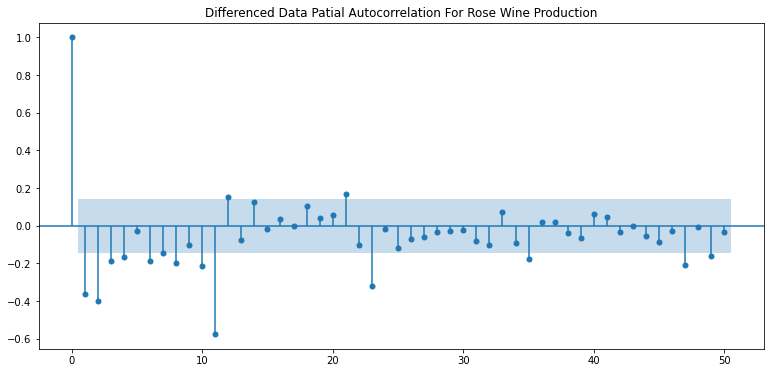

In [163]:
plot_acf(ds['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation for Rose Wine Production')
plot_pacf(ds['Rose'].diff().dropna(),lags=50,title='Differenced Data Patial Autocorrelation For Rose Wine Production')
plt.show()

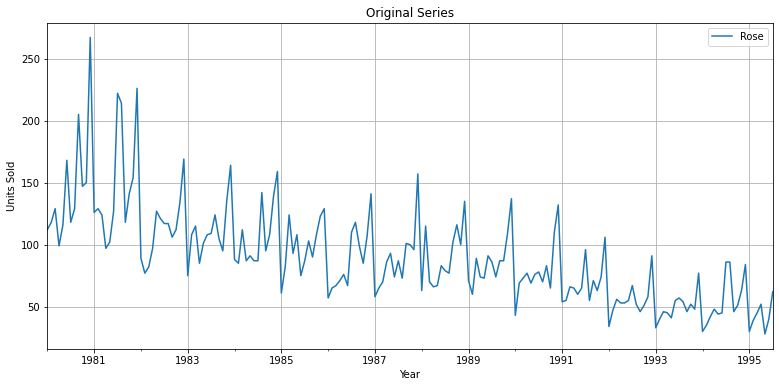

In [164]:
ds.plot()
plt.title("Original Series")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.grid();

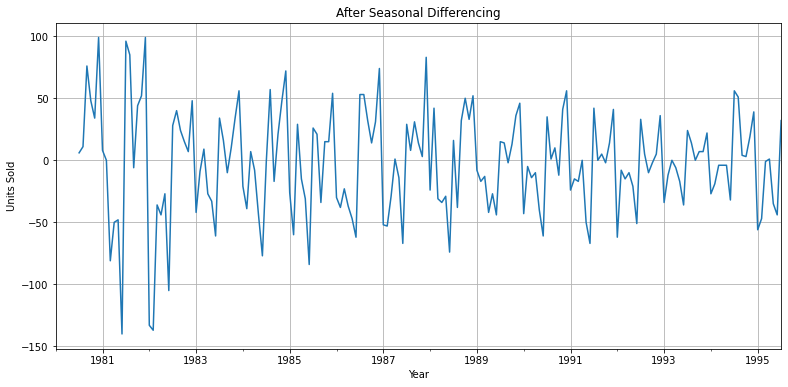

In [165]:
(ds['Rose'].diff(6)).plot()
plt.title("After Seasonal Differencing")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.grid();

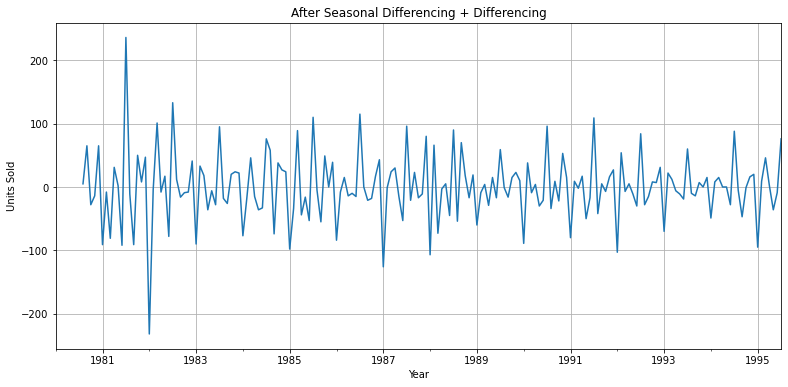

In [166]:
(ds['Rose'].diff(6)).diff().plot()
plt.title("After Seasonal Differencing + Differencing")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.grid();

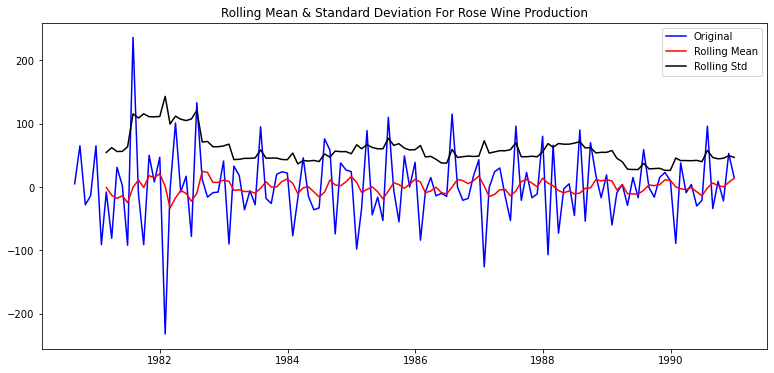

Results of Dickey-Fuller Test:
Test Statistic                -6.882869e+00
p-value                        1.418693e-09
#Lags Used                     1.300000e+01
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
dtype: float64 

Test Statistic                -6.882869e+00
p-value                        1.418693e-09
#Lags Used                     1.300000e+01
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
dtype: float64 

Test Statistic                -6.882869e+00
p-value                        1.418693e-09
#Lags Used                     1.300000e+01
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64 



In [167]:
test_stationarity((train['Rose'].diff(6).dropna()).diff(1).dropna())

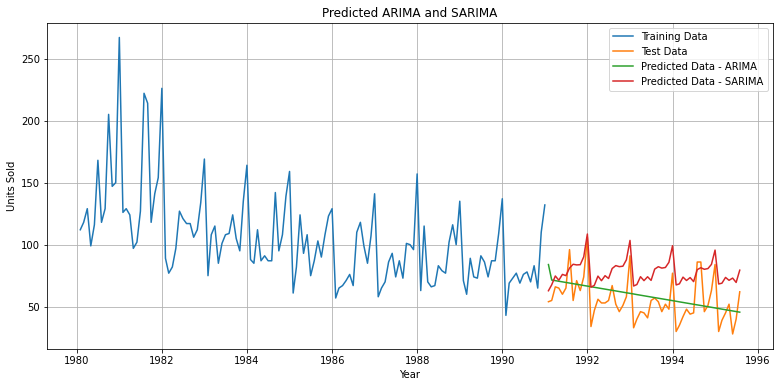

In [168]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,predicted_auto_ARIMA[0],label='Predicted Data - ARIMA')
plt.plot(test.index,predicted_auto_SARIMA_6.predicted_mean,label='Predicted Data - SARIMA')
plt.legend(loc='best')
plt.title("Predicted ARIMA and SARIMA")
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.grid();

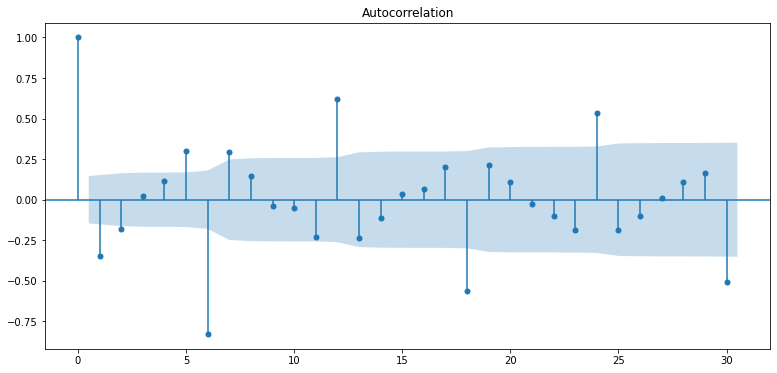

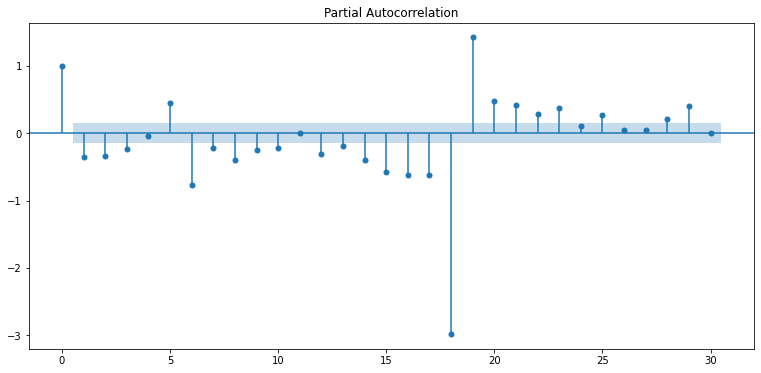

In [169]:
plot_acf((ds['Rose'].diff(6).dropna()).diff(1).dropna(),lags=30)
plot_pacf((ds['Rose'].diff(6).dropna()).diff(1).dropna(),lags=30);

In [170]:
manual_SARIMA_6 = sm.tsa.statespace.SARIMAX(train['Rose'].values,order=(3, 1, 2),seasonal_order=(3, 1, 2, 6),enforce_stationarity=False,enforce_invertibility=False)
results_manual_SARIMA_6 = manual_SARIMA_6.fit(maxiter=1000)
print(results_manual_SARIMA_6.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 6)   Log Likelihood                -444.189
Date:                           Tue, 12 Jul 2022   AIC                            910.378
Time:                                   22:29:52   BIC                            939.466
Sample:                                        0   HQIC                           922.162
                                           - 132                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7725      0.141     -5.492      0.000      -1.048      -0.497
ar.L2          0.0500      0.173      0.288

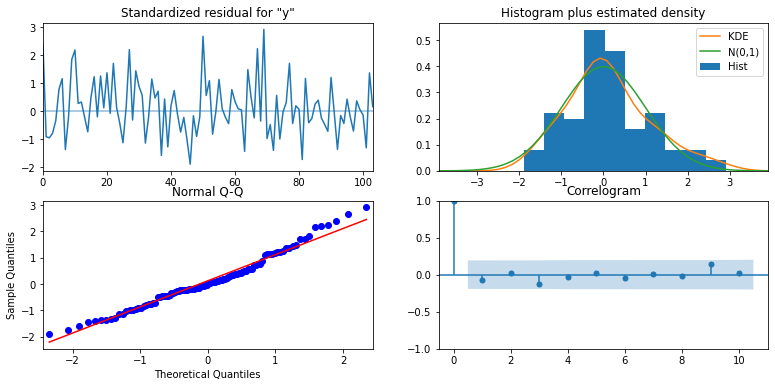

In [171]:
results_manual_SARIMA_6.plot_diagnostics()
plt.show()

In [172]:
predicted_manual_SARIMA_6 = results_manual_SARIMA_6.get_forecast(steps=len(test))

In [173]:
predicted_manual_SARIMA_6.summary_frame(alpha=0.05).head()

y       mean    mean_se  mean_ci_lower  mean_ci_upper
0  50.125559  17.064961      16.678850      83.572268
1  61.105969  17.995985      25.834487      96.377452
2  72.845444  18.000126      37.565846     108.125042
3  72.596869  18.178016      36.968612     108.225126
4  69.221498  18.243959      33.463995     104.979001

In [174]:
rmse = mean_squared_error(test['Rose'],predicted_manual_SARIMA_6.predicted_mean,squared=False)
print(rmse)

19.241787418157713


In [175]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse]},index=['SARIMA(3,1,2)(3,1,2,6)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                        50.57
Naïve's Model                                           78.49
SimpleAverageModel                                      52.37
2pointTrailingMovingAverage                             12.16
4pointTrailingMovingAverage                             15.57
6pointTrailingMovingAverage                             15.69
9pointTrailingMovingAverage                             16.16
Alpha=0.098,SimpleExponentialSmoothing                  35.93
Alpha=0.3,SimpleExponentialSmoothing                    46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing           97.05
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...      20.40
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...      13.01
ARIMA(0,1,2)                                            16.93
SARIMA(1,1,2)(2,0,2,6)                                  25.28
SARIMA(0,1,2)(2,0,2,12)                                 26.35
ARIMA(3,1,2)                                            16.85
SARIMA(3,1,2)(3,1,2,6)                                  19.24

In [176]:
manual_SARIMA_12 = sm.tsa.statespace.SARIMAX(train['Rose'].values,order=(3, 1, 2),seasonal_order=(3, 1, 2, 12),enforce_stationarity=False,enforce_invertibility=False)
results_manual_SARIMA_12 = manual_SARIMA_12.fit(maxiter=1000)
print(results_manual_SARIMA_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -331.007
Date:                            Tue, 12 Jul 2022   AIC                            684.014
Time:                                    22:30:05   BIC                            710.217
Sample:                                         0   HQIC                           694.519
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8548      0.184     -4.645      0.000      -1.215      -0.494
ar.L2          0.0005      0.195   

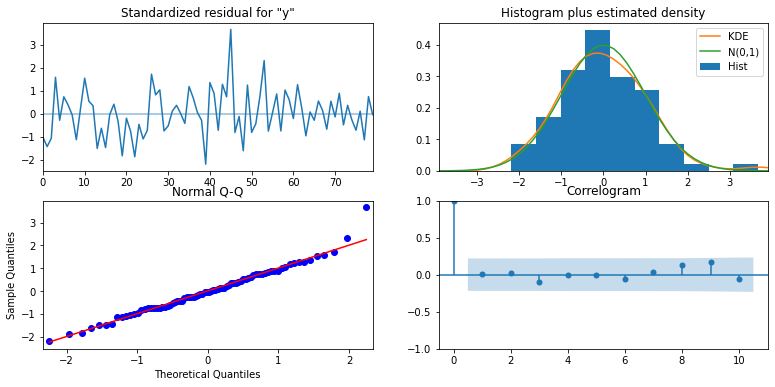

In [177]:
results_manual_SARIMA_12.plot_diagnostics()
plt.show()

In [178]:
predicted_manual_SARIMA_12 = results_manual_SARIMA_12.get_forecast(steps=len(test))

In [179]:
predicted_manual_SARIMA_12.summary_frame(alpha=0.05).head()

y       mean    mean_se  mean_ci_lower  mean_ci_upper
0  42.132852  14.295405      14.114374      70.151330
1  62.518854  14.373552      34.347209      90.690498
2  65.956178  14.386526      37.759104      94.153252
3  64.342775  14.478618      35.965205      92.720346
4  67.170266  14.493497      38.763533      95.576999

In [180]:
rmse = mean_squared_error(test['Rose'],predicted_manual_SARIMA_12.predicted_mean,squared=False)
print(rmse)

16.983102683777727


In [181]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse]},index=['SARIMA(3,1,2)(3,1,2,12)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
round(resultsDf,2)

Test RMSE
RegressionOnTime                                        50.57
Naïve's Model                                           78.49
SimpleAverageModel                                      52.37
2pointTrailingMovingAverage                             12.16
4pointTrailingMovingAverage                             15.57
6pointTrailingMovingAverage                             15.69
9pointTrailingMovingAverage                             16.16
Alpha=0.098,SimpleExponentialSmoothing                  35.93
Alpha=0.3,SimpleExponentialSmoothing                    46.47
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing           97.05
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...      20.40
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...      13.01
ARIMA(0,1,2)                                            16.93
SARIMA(1,1,2)(2,0,2,6)                                  25.28
SARIMA(0,1,2)(2,0,2,12)                                 26.35
ARIMA(3,1,2)                                            16.85
SARIMA(3,1,2)(3,1,2,6)                                  19.24
SARIMA(3,1,2)(3,1,2,12)                                 16.98

# 8. Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [182]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse]},index=['SARIMA(1,1,2)(2,0,2,6)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

Test RMSE
RegressionOnTime                                    50.572900
Naïve's Model                                       78.485320
SimpleAverageModel                                  52.369847
2pointTrailingMovingAverage                         12.158798
4pointTrailingMovingAverage                         15.572375
6pointTrailingMovingAverage                         15.687446
9pointTrailingMovingAverage                         16.161176
Alpha=0.098,SimpleExponentialSmoothing              35.931340
Alpha=0.3,SimpleExponentialSmoothing                46.473062
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing       97.053293
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...  20.398003
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...  13.014696
ARIMA(0,1,2)                                        16.933991
SARIMA(1,1,2)(2,0,2,6)                              25.283081
SARIMA(0,1,2)(2,0,2,12)                             26.345253
ARIMA(3,1,2)                                        16.847372
SARIMA(3,1,2)(3,1,2,6)                              19.241787
SARIMA(3,1,2)(3,1,2,12)                             16.983103
SARIMA(1,1,2)(2,0,2,6)                              16.983103

In [183]:
print('Sorted by RMSE values on the Test Data for Rose Wine sale:','\n',)
resultsDf.sort_values(by=['Test RMSE'])

Sorted by RMSE values on the Test Data for Rose Wine sale: 



Test RMSE
2pointTrailingMovingAverage                         12.158798
Alpha=0.3,Beta=0.4,Gamma=0.3,Triple Exponential...  13.014696
4pointTrailingMovingAverage                         15.572375
6pointTrailingMovingAverage                         15.687446
9pointTrailingMovingAverage                         16.161176
ARIMA(3,1,2)                                        16.847372
ARIMA(0,1,2)                                        16.933991
SARIMA(1,1,2)(2,0,2,6)                              16.983103
SARIMA(3,1,2)(3,1,2,12)                             16.983103
SARIMA(3,1,2)(3,1,2,6)                              19.241787
Alpha=0.106,Beta=0.048,Gamma=0.0,TripleExponent...  20.398003
SARIMA(1,1,2)(2,0,2,6)                              25.283081
SARIMA(0,1,2)(2,0,2,12)                             26.345253
Alpha=0.098,SimpleExponentialSmoothing              35.931340
Alpha=0.3,SimpleExponentialSmoothing                46.473062
RegressionOnTime                                    50.572900
SimpleAverageModel                                  52.369847
Naïve's Model                                       78.485320
Alpha=0.3,Beta=0.1,DoubleExponentialSmoothing       97.053293

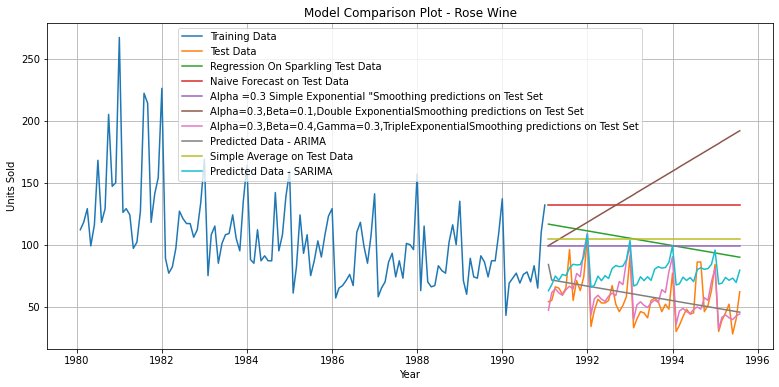

In [184]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(LinearRegression_test['RegOnTime'],label='Regression On Sparkling Test Data')
plt.plot(NaiveModel_test['naive'],label='Naive Forecast on Test Data')
plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 Simple Exponential "Smoothing predictions on Test Set')
plt.plot(DES_test['predict', 0.3, 0.1], label='Alpha=0.3,Beta=0.1,Double ExponentialSmoothing predictions on Test Set')
plt.plot(TES_test['predict', 0.3, 0.4, 0.3], label='Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')
plt.plot(test.index,predicted_auto_ARIMA[0],label='Predicted Data - ARIMA')
plt.plot(SimpleAverage_test['mean_forecast'],label='Simple Average on Test Data')
plt.plot(test.index,predicted_auto_SARIMA_6.predicted_mean,label='Predicted Data - SARIMA')
plt.title('Model Comparison Plot - Rose Wine')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend(loc='best')
plt.grid();

# 9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

### Building the most optimum model on the Full Data

### Plotting on both the Training and Test data

Text(0, 0.5, 'Units Sold')

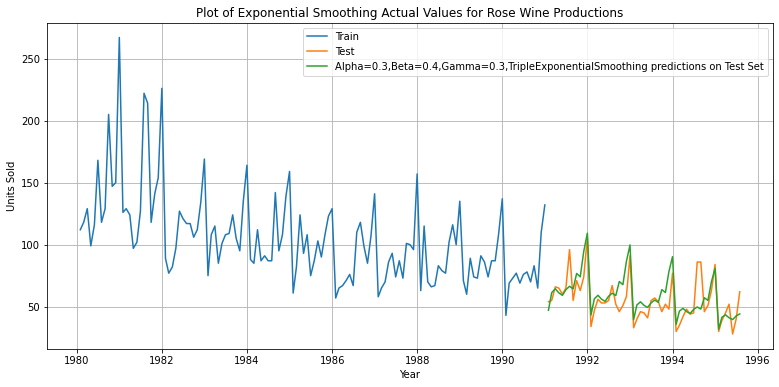

In [185]:
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(TES_test['predict', 0.3, 0.4, 0.3], label='Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid();
plt.title('Plot of Exponential Smoothing Actual Values for Rose Wine Productions');
plt.xlabel('Year')
plt.ylabel('Units Sold')

In [186]:
fullmodel = ExponentialSmoothing(ds,trend='additive',seasonal='multiplicative').fit(smoothing_level=0.3,smoothing_slope=0.4,smoothing_seasonal=0.3)

In [187]:
print(fullmodel.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     Rose   No. Observations:                  187
Model:             ExponentialSmoothing   SSE                          84348.590
Optimized:                         True   AIC                           1174.870
Trend:                         Additive   BIC                           1226.568
Seasonal:                Multiplicative   AICC                          1178.942
Seasonal Periods:                    12   Date:                 Tue, 12 Jul 2022
Box-Cox:                          False   Time:                         22:30:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha                False
smoothing_trend          

In [188]:
RMSE_fullmodel = metrics.mean_squared_error(ds['Rose'],fullmodel.fittedvalues,squared=False)
print('RMSE:',RMSE_fullmodel)

RMSE: 21.238219810247514


### Getting the predictions for the same number of times stamps that are present in the test data

In [189]:
prediction=fullmodel.forecast(steps=12)

Text(0, 0.5, 'Units Sold')

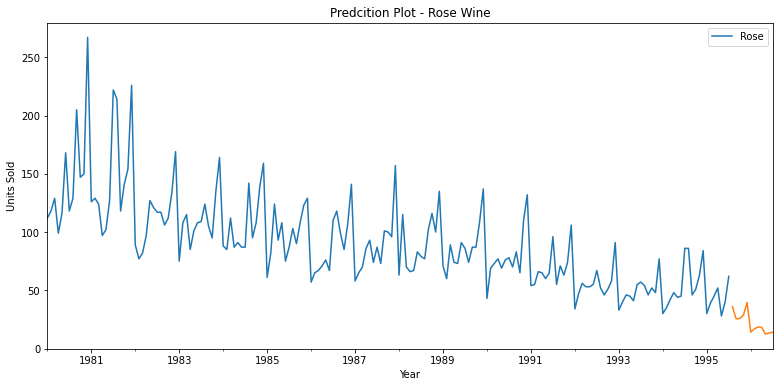

In [190]:
ds.plot()
prediction.plot();
plt.title('Predcition Plot - Rose Wine')
plt.xlabel('Year')
plt.ylabel('Units Sold')

In [191]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level
#The percentile function under numpy lets us calculate these and adding and subtracting from the predictions
#gives us the necessary confidence bands for the predictions
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(fullmodel.resid,ddof=1),'prediction':prediction,'upper_ci': prediction + 1.96*np.std(fullmodel.resid,ddof=1)})
pred_df.head()

lower_CI  prediction   upper_ci
1995-08-31  -5.718613   36.000982  77.720578
1995-09-30 -16.170707   25.548888  67.268484
1995-10-31 -15.948390   25.771206  67.490801
1995-11-30 -13.010412   28.709184  70.428779
1995-12-31  -2.215944   39.503651  81.223247

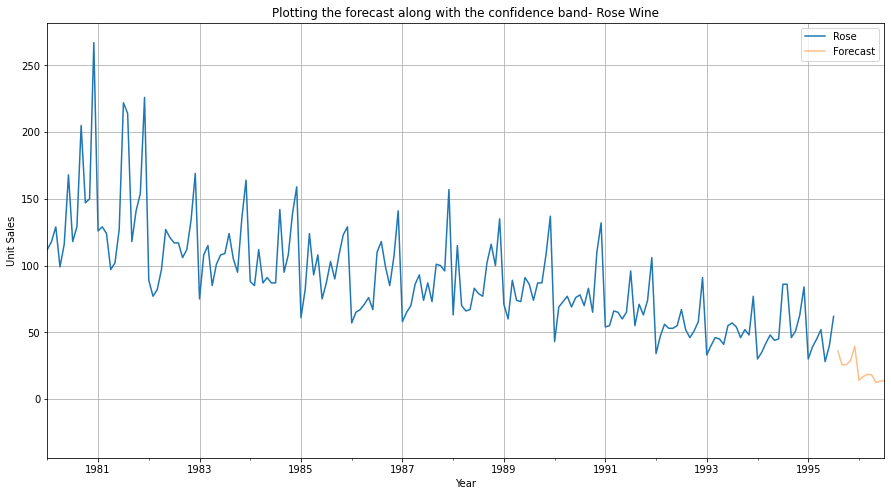

In [192]:
axis=ds.plot(label='Actual',figsize=(15,8))
pred_df['prediction'].plot(ax=axis,label='Forecast',alpha=0.5)
axis.fill_between(pred_df.index,pred_df['lower_CI'],pred_df['upper_ci'],color='k',alpha=0)
plt.title('Plotting the forecast along with the confidence band- Rose Wine')
axis.set_xlabel('Year')
axis.set_ylabel('Unit Sales')
plt.legend(loc='best')
plt.grid()
plt.show()

In [193]:
full_data_model = sm.tsa.statespace.SARIMAX(ds['Rose'],
                                order=(0,1,2),
                                seasonal_order=(2, 0, 2, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
print(results_full_data_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              Rose   No. Observations:                  187
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 6)   Log Likelihood                -737.093
Date:                           Tue, 12 Jul 2022   AIC                           1488.186
Time:                                   22:30:11   BIC                           1510.178
Sample:                               01-31-1980   HQIC                          1497.109
                                    - 07-31-1995                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7061      0.075     -9.447      0.000      -0.853      -0.560
ma.L2         -0.2184      0.069     -3.157

In [194]:
full_data_model = sm.tsa.statespace.SARIMAX(ds['Rose'],
                                order=(1,1,2), 
                                seasonal_order=(1,0,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
print(results_full_data_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Rose   No. Observations:                  187
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -664.810
Date:                            Tue, 12 Jul 2022   AIC                           1343.621
Time:                                    22:30:13   BIC                           1365.103
Sample:                                01-31-1980   HQIC                          1352.345
                                     - 07-31-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1174      0.287     -0.409      0.683      -0.680       0.446
ma.L1         -0.5959      0.292   

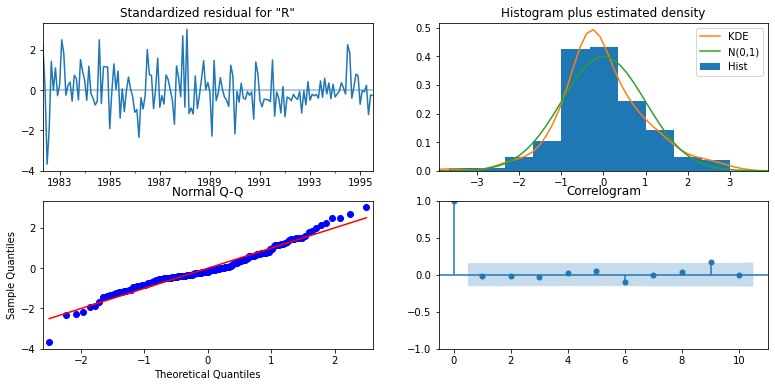

In [195]:
results_full_data_model.plot_diagnostics();

In [196]:
predicted_manual_SARIMA_6_full_data = results_full_data_model.get_forecast(steps=12)

In [197]:
predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).head()

Rose             mean    mean_se  mean_ci_lower  mean_ci_upper
1995-08-31  65.047948  15.730644      34.216452      95.879444
1995-09-30  45.791280  16.364500      13.717449      77.865110
1995-10-31  49.327141  16.392000      17.199411      81.454871
1995-11-30  53.914232  16.448909      21.674963      86.153502
1995-12-31  69.056858  16.501631      36.714256     101.399461

In [198]:
rmse = mean_squared_error(ds['Rose'],results_full_data_model.fittedvalues,squared=False)
print('RMSE of the Full Model',rmse)

RMSE of the Full Model 28.874997095434463


In [199]:
pred_full_manual_SARIMA_date = predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).set_index(pd.date_range(start='1995-08-31',end='1996-07-31', freq='M'))

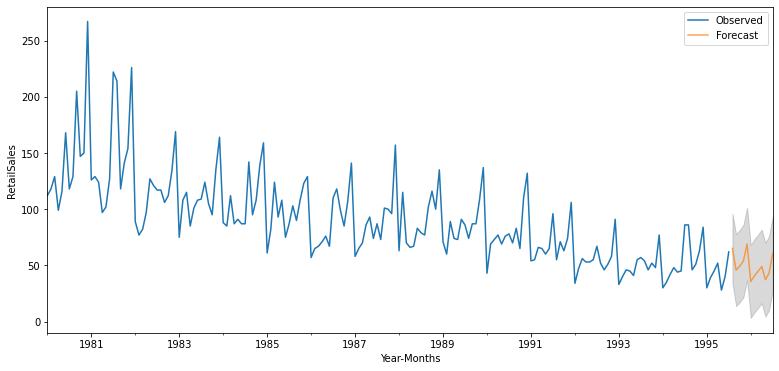

In [200]:
# plot the forecast along with the confidence band

axis = ds['Rose'].plot(label='Observed')
pred_full_manual_SARIMA_date['mean'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(pred_full_manual_SARIMA_date.index, pred_full_manual_SARIMA_date['mean_ci_lower'], 
                  pred_full_manual_SARIMA_date['mean_ci_upper'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('RetailSales')
plt.legend(loc='best')
plt.show()